<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_09_auto_ml_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Tuning

In [0]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

In [0]:
#!pip install -U imblearn
#!pip install -U xgboost
# !pip install -U featuretools

# https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
# https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
# https://machinelearningmastery.com/imbalanced-classification-model-to-detect-oil-spills/

In [3]:
if COLAB:
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects

Cloning into 'dl-projects'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 1878 (delta 47), reused 7 (delta 3), pack-reused 1802
Receiving objects: 100% (1878/1878), 77.12 MiB | 34.55 MiB/s, done.
Resolving deltas: 100% (1158/1158), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

In [0]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys
import gc

from scipy import stats
from collections import Counter
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import featuretools as ft
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, make_scorer, recall_score, roc_curve, mean_squared_error, accuracy_score, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     AllKNN,
                                     NearMiss,
                                     OneSidedSelection,
                                     EditedNearestNeighbours)
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN 
import pylab as pl
import xgboost as xgb
from collections import Counter
from dateutil.relativedelta import relativedelta


# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
# from scikitplot.plotters import plot_precision_recall_curve

from utils import feature_selection, plot_feature_importances
from preprocess import *
from plot import plot_correlation_matrix, plot_labeled_scatter

from IPython.display import display

np.set_printoptions(threshold=sys.maxsize)

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [7]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [8]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [9]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("../datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 4720M
-rw------- 1 root root 2454M Jan 12 01:24 feature_matrix_d2_v2.ft
-rw------- 1 root root 1585M Jan 12 23:39 feature_matrix_d2_v3.ft
-rw------- 1 root root   17M Feb 21 13:07 feature_matrix_snapshot.ft
-rw------- 1 root root   17M Feb 21 13:07 feature_matrix_snapshot_origin.pkl
-rw------- 1 root root    5M Jan 30 04:33 orig_X_test.ft
-rw------- 1 root root  415M Jan 30 04:33 orig_X_train.ft
-rw------- 1 root root    1M Jan 30 04:33 orig_y_test.ft
-rw------- 1 root root    7M Jan 30 04:33 orig_y_train.ft
-rw------- 1 root root    3M Feb 29 08:34 test_X_test.ft
-rw------- 1 root root  213M Feb 29 08:34 test_X_train.ft
-rw------- 1 root root    1M Feb 29 08:34 test_y_test.ft
-rw------- 1 root root    7M Feb 29 08:34 test_y_train.ft
total 25M
-rw-r--r-- 1 root root  1M Feb 29 12:49 4D.zip
-rw-r--r-- 1 root root 25M Feb 29 12:49 labels.csv


In [0]:
# Read the data
data = pd.read_feather(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

## Exploratory Data Analysis

### View data

In [0]:
# Feature matrix
feature_matrix = data.drop(columns=['NumberId', 'month', 'year'])

In [12]:
# Sort data
feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959893 entries, 7020 to 956511
Columns: 214 entries, time to LAST(Results.PrizeType)_Prize
dtypes: datetime64[ns](1), float64(155), int64(56), uint8(2)
memory usage: 1.5 GB


In [13]:
print('Distribution')
print(feature_matrix['Label'].value_counts())
print()
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Distribution
0    927839
1     32054
Name: Label, dtype: int64

Positive: 927839 which is  96.66 % of the dataset
Negative: 32054 which is  3.34 % of the dataset


In [14]:
feature_matrix.isna().sum().sort_values(ascending=False)

SKEW(Results.TIME_SINCE_PREVIOUS(DrawDate))               7636
CUM_MEAN(TREND(Results.LuckyNo, DrawDate))                7636
TREND(Results.TIME_SINCE_PREVIOUS(DrawDate), DrawDate)    7636
TREND(Results.CUM_MEAN(TotalStrike), DrawDate)            7636
TREND(Results.CUM_SUM(LuckyNo), DrawDate)                 7636
                                                          ... 
CUM_SUM(MIN(Results.DrawNo))                                 0
NUM_UNIQUE(Results.DAY(DrawDate))                            0
NUM_UNIQUE(Results.MONTH(DrawDate))                          0
SUM(Results.PERCENTILE(LuckyNo))                             0
time                                                         0
Length: 214, dtype: int64

### Feature Selection

In [0]:
# Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [16]:
feature_matrix.shape

(959893, 214)

In [17]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label']))
# feature_matrix_selection = feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label'])

Original shape:  (959893, 211)
0 missing columns with threshold: 90.
41 zero variance columns.
109 collinear columns removed with threshold: 0.95.
Total columns removed:  150
Shape after feature selection: (959893, 61).


In [18]:
feature_matrix_selection.shape, feature_matrix_selection.columns

((959893, 61),
 Index(['STD(Results.DrawNo)', 'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
        'TREND(Results.DrawNo, DrawDate)', 'MONTH(first_Results_time)',
        'DAY(first_Results_time)', 'TIME_SINCE(first_Results_time)',
        'TIME_SINCE_PREVIOUS(first_Results_time)',
        'STD(Results.PERCENTILE(DrawNo))',
        'STD(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'STD(Results.CUM_SUM(DrawNo))', 'STD(Results.CUM_MEAN(LuckyNo))',
        'MAX(Results.PERCENTILE(DrawNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MAX(Results.CUM_MEAN(LuckyNo))',
        'MIN(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'MIN(Results.CUM_MEAN(LuckyNo))', 'MODE(Results.MONTH(DrawDate))',
        'MODE(Results.DAY(DrawDate))', 'MEAN(Results.TIME_SINCE(DrawDate))',
       

In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['TotalStrike'] = feature_matrix['TotalStrike']
feature_matrix_selection['Label'] = feature_matrix['Label']

### Feature Correlation

In [20]:
feature_matrix.isnull().sum().sort_values(ascending=False)

LAST(Results.PrizeType)_Prize                  0
SKEW(Results.TIME_SINCE(DrawDate))             0
MEAN(Results.CUM_MEAN(TotalStrike))            0
MEAN(Results.CUM_MEAN(LuckyNo))                0
MEAN(Results.CUM_SUM(DrawNo))                  0
                                              ..
CUM_SUM(COUNT(Results))                        0
CUM_SUM(MAX(Results.DrawNo))                   0
CUM_SUM(MEAN(Results.LuckyNo))                 0
CUM_SUM(AVG_TIME_BETWEEN(Results.DrawDate))    0
time                                           0
Length: 214, dtype: int64

In [0]:
# Check with feature selection
corrs = feature_matrix_selection.corr().sort_values('Label')

In [22]:
corrs['Label'].head(60)

CUM_MEAN(SUM(Results.LuckyNo))                           -0.003288
TIME_SINCE(first_Results_time)                           -0.002944
STD(Results.DrawNo)                                      -0.002877
STD(Results.CUM_SUM(DrawNo))                             -0.002778
MAX(Results.LuckyNo)                                     -0.002680
SUM(Results.LuckyNo)                                     -0.002426
MAX(Results.DrawNo)                                      -0.002377
MIN(Results.CUM_MEAN(LuckyNo))                           -0.002333
CUM_MEAN(AVG_TIME_BETWEEN(Results.DrawDate))             -0.002238
MEAN(Results.TIME_SINCE(DrawDate))                       -0.002056
STD(Results.PERCENTILE(DrawNo))                          -0.001937
PERCENTILE(STD(Results.LuckyNo))                         -0.001931
PERCENTILE(STD(Results.DrawNo))                          -0.001814
CUM_SUM(SKEW(Results.DrawNo))                            -0.001741
SUM(Results.TIME_SINCE(DrawDate))                        -0.00

## Modeling

In [0]:
def recall_optim(y_true, y_pred):
    """Make a scoring function that improves specificity while identifying all strikes
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Recall will be worth a greater value than specificity
    rec = recall_score(y_true, y_pred) * 0.8 
    spe = conf_matrix[0,0]/conf_matrix[0,:].sum() * 0.2 
    
    # Imperfect recalls will lose a penalty
    # This means the best results will have perfect recalls and compete for specificity
    if rec < 0.8:
        rec -= 0.2
    return rec + spe 


# Make a scoring callable from recall_score
recall = make_scorer(recall_score)

# Create a scoring callable based on the scoring function
optimize = make_scorer(recall_optim)

# Geometric mean scorer
geo_mean_scorer = make_scorer(geometric_mean_score)

# DataFrame to store classifier performance
performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity', 'Optimize'])

def to_labels(pos_probs, threshold):
    """Apply threshold to positive probabilities to create labels.
    """
    return (pos_probs >= threshold).astype('int')
 

def score_optimization(dt, feature_matrix, clf, params, X_train, y_train, X_test, y_test, skip_grid_search_cv=False, optimized_scorer=False):
    """Find the optimized classifier.
    """
    if not skip_grid_search_cv:
      print("\nFinding the optimized classifier...")

      # Load GridSearchCV
      # search = GridSearchCV(
      search = RandomizedSearchCV(
            estimator=clf,
            #param_grid=params,
            param_distributions=params,
            n_jobs=4,
            scoring=optimize  # Use custom scorer
      )

      # Train search object
      search.fit(X_train, y_train)

      # Heading
      print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

      # Extract best estimator
      best = search.best_estimator_
      print('Best parameters: \n\n',search.best_params_,'\n')
    
    else:
      print("\nUse the passed in classifier...\n")
      best = clf

    # Cross-validate on the train data
    if not skip_grid_search_cv: 
      print("TRAIN GROUP")
      #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
      cv = 3
      if not optimized_scorer:
        print('\nUse default scorer')
        train_cv = cross_val_score(
                                  n_jobs=4,
                                  X=X_train, 
                                  y=y_train, 
                                  estimator=best, 
                                  scoring=recall,
                                  cv=cv)
      else:
        print('\nUse optimized scorer')
        train_cv = cross_val_score(
                                  n_jobs=4,
                                  X=X_train, 
                                  y=y_train, 
                                  estimator=best, 
                                  #scoring=optimize,
                                  scoring='roc_auc',
                                  #scoring=geo_mean_scorer,
                                  cv=cv)

      print("\nCross-validation recall scores:",train_cv)
      print("Mean recall score:",train_cv.mean())
      print('Mean G-Mean: %.3f (%.3f)' % (np.mean(train_cv), np.std(train_cv)))
    else:
      train_cv = np.zeros(3)

    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = best.fit(X_train, y_train).predict(X_test)
    # y_pred = best.fit(X_train, y_train,
    #                   eval_set=[(X_test, y_test)],
    #                   eval_metric='auc',
    #                   early_stopping_rounds=10,
    #                   verbose=True
    #                   ).predict(X_test)

    # keep probabilities for the positive outcome only
    probas = best.predict_proba(X_test)[:, 1]
    
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)

    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(probas, t)) for t in thresholds]

    # get best threshold
    ix = np.argmax(scores)
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

    # print recall
    print("\nRecall:",recall_score(y_test,y_pred))

    # Get imbalanced classification report
    print(classification_report_imbalanced(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()

    # Store results
    performance.loc[clf.__class__.__name__+'_optimize',:] = [
        train_cv.mean(),
        recall_score(y_test,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum(),
        recall_optim(y_test,y_pred)
    ]
    # Look at the parameters for the top best scores
    if not skip_grid_search_cv:
      display(pd.DataFrame(search.cv_results_).iloc[:,4:].sort_values(by='rank_test_score').head())
    display(performance)

    # Additionl info
    print('\n\nAdditional Info')
    print('='*40)
    positive = np.where((y_pred==1))
    print(f'Total predicted to be positive: {len(positive[0])} \n')

    pred = np.where((y_pred==1))
    all_preds = pred[0]

    # Total predicted matches
    print('First 23 matches')
    print(23, all_preds[0:23])
    print(f'\n{probas[all_preds[0:23]]}\n') 

    print("\nTop 23 Probable Matches")
    #print('probas', probas)
    topN = np.argpartition(probas, -23)[-23:]
    print(f'\n{topN}\n')          # Top N most high probability numbers
    print(f'\n{probas[topN]}\n')  # Top N probability

    # Check for 2 to 3 digits range 
    print('\n2 To 3 Digits\n')
    idx_range = np.where((all_preds < 1000) & (all_preds >= 10))
    #print(idx_range)
    range_numbers = all_preds[idx_range]
    print(len(range_numbers), range_numbers)
    print(f'\n{probas[range_numbers]}\n') 


    # 2 to 3 Digits > Average Probas
    print('\n2 To 3 Digits Average Proba\n')
    avg_proba = np.average(probas[range_numbers])
    print(f'Average proba {avg_proba}\n')
    idx_avg_proba = np.where(probas > avg_proba) 
    print(len(idx_avg_proba[0]), idx_avg_proba[0])

    # 2 to 3 Digits > All Average Probas
    print('\n\nAll Average Proba\n')
    all_avg_proba = np.average(probas[all_preds])
    print(f'All average probas {all_avg_proba}\n')
    idx_all_avg_proba = np.where(probas > all_avg_proba) 
    print(len(idx_all_avg_proba[0]), idx_all_avg_proba[0])


    # All predicted matches
    print('\n\nAll Predictions\n')
    print(len(all_preds), all_preds)
    print()
    print(len(probas[all_preds]), probas[all_preds])
    
    #print('Debug')
    #print(pred)
    
    if len(positive[0]) > 0:
    
      # Matching draws
      print('\nMatched draws')
      md = np.where((y_pred==1) & (y_test==1))
      print(f"Count: {len(md[0])}, Index: {md}")
      month_data = feature_matrix.loc[feature_matrix['time'] == dt]
      numbers = month_data.iloc[md[0]][['MAX(Results.LuckyNo)']]

      print('\n\nTop 23 Possibility')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(topN))].head(23))  
      
      print('\n\nFirst 23 Numbers')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(pred[0][0:23]))].head(23))    
             

      print('\n\n2 To 3 Digits Numbers')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(range_numbers))].head(23))    
     

      print('\n\nAll matched')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(numbers['MAX(Results.LuckyNo)']))].head(100))    
                                                  
    else:
      print('No luck this month')  

    if len(range_numbers) >= 50:
      return False

    return True

In [0]:
def remove_outliers(balanced, threshold=0.001, remove=True):
    """Removing Outliers from high-correlation features.
    """

    if not remove:
      return balanced

    bal_corr = balanced.corr()
    no_outliers=pd.DataFrame(balanced.copy())

    cols = bal_corr.Label.index[:-1]

    # For each feature correlated with Class...
    for col in cols:
        # If absolute correlation value is more than X percent...
        correlation = bal_corr.loc['Label',col]

        if np.absolute(correlation) > threshold:
          # Separate the classes of the high-correlation column
          nonstrikes = no_outliers.loc[no_outliers.Label==0,col]
          strikes = no_outliers.loc[no_outliers.Label==1,col]

          # Identify the 25th and 75th quartiles
          all_values = no_outliers.loc[:,col]
          q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
          # Get the inter quartile range
          iqr = q75 - q25
          # Smaller cutoffs will remove more outliers
          cutoff = iqr * 7
          # Set the bounds of the desired portion to keep
          lower, upper = q25 - cutoff, q75 + cutoff
          
          # If positively correlated...
          # Drop nonstrikes above upper bound, and strikes below lower bound
          if correlation > 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes>upper].index,inplace=True)
              no_outliers.drop(index=strikes[strikes<lower].index,inplace=True)
          
          # If negatively correlated...
          # Drop non strikes below lower bound, and strikes above upper bound
          elif correlation < 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes<lower].index,inplace=True)
              no_outliers.drop(index=strikes[strikes>upper].index,inplace=True)
        
    print('\nData shape before removing outliers:', balanced.shape)
    print('\nCounts of strikes VS non-strikes in previous data:')
    print(balanced.Label.value_counts())
    print('-'*40)
    print('-'*40)
    print('\nData shape after removing outliers:', no_outliers.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(no_outliers.Label.value_counts())

    # no_outliers.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    # plt.title('Distributions with Less Outliers', fontsize=17)
    # plt.show()
    
    no_outliers.reset_index(drop=True, inplace=True)
    return no_outliers


def filter_features(no_outliers, threshold=0.001):
    """Feature selection.
    """
    feat_sel = pd.DataFrame(no_outliers.copy())

    # Make a dataframe with the label-correlations before removing outliers
    # corr_change = pd.DataFrame()
    # corr_change['correlation']= bal_corr.Label
    # corr_change['origin']= 'w/outliers'

    # Make a dataframe with label-correlations after removing outliers 
    # corr_other = pd.DataFrame()
    # corr_other['correlation']= feat_sel.corr().Label
    # corr_other['origin']= 'no_outliers'

    # Join them
    # corr_change = corr_change.append(corr_other)

    # plt.figure(figsize=(14,6))
    # plt.xticks(rotation=90)

    # Plot them
    # sns.set_style('darkgrid')
    # plt.title('Label correlation per feature. With vs without outliers', fontsize=17)
    # sns.barplot(data=corr_change,x=corr_change.index,y='correlation',hue='origin')
    # plt.show()

    # Feature Selection based on correlation with label

    print('\nData shape before feature selection:', feat_sel.shape)
    print('\nCounts of strikes vs non-strikes before feature selection:')
    print(feat_sel.Label.value_counts())
    print('-'*40)

    # Correlation matrix after removing outliers
    new_corr = feat_sel.corr()

    for col in new_corr.Label.index[:-1]:
        # Pick desired cutoff for dropping features. In absolute-value terms.
        if np.absolute(new_corr.loc['Label',col]) < threshold:
            # Drop the feature if correlation is below cutoff
            feat_sel.drop(columns=col,inplace=True)

    print('-'*40)
    print('\nData shape after feature selection:', feat_sel.shape)
    print('\nCounts of strikes vs non-strikes in new data:')
    print(feat_sel.Label.value_counts())

    return feat_sel

    # feat_sel.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    # plt.title('Distribution of Features Selected', fontsize=17)
    # plt.show()

def under_sampler(data, sample_size=20000, sampling=False):
    # Undersample model for efficiency and balance classes.

    X_train = data.drop('Label',1)
    y_train = data.Label

    if not sampling:
      return X_train, y_train

    # After feature-selection, X_test needs to include only the same features as X_train
    # cols = X_train.columns
    # X_test = X_test[cols]

    # Undersample and balance classes
    X_train, y_train = RandomUnderSampler(sampling_strategy={1:sample_size,0:sample_size}).fit_resample(X_train,y_train)

    print('\nX_train shape after reduction:', X_train.shape)
    print('\nCounts of strikes VS non-strikes in y_train:')
    print(np.unique(y_train, return_counts=True))

    return X_train, y_train

In [0]:
def gen_train_test_set(dt, feature_matrix, file_prefix='data'): 
    
    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['time'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['time'] < dt, 'Label']

    # Features
    X_train = feature_matrix[feature_matrix['time'] < dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['time'] == dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    feature_names = list(X_train.columns)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))

    # Join the train data
    train = X_train.join(train_labels)

    print('Data shape before balancing:', train.shape)
    print('\nCounts of strikes vs non-strikes in previous data:')
    print(train.Label.value_counts())
    print('-'*40)

    # sklearn pipeline
    pipeline = make_pipeline(
        SimpleImputer(strategy = 'constant', fill_value=0),
        StandardScaler())
    
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    # imblearn pipeline
    imb_pipeline = make_pipeline_imb(
          # NearMiss(version=3, n_neighbors_ver3=3, n_jobs=4)
          # SMOTE(sampling_strategy='minority',random_state=42, n_jobs=4)
          # ADASYN(sampling_strategy='minority',random_state=42, n_jobs=4)
          # OneSidedSelection(n_neighbors=1, n_seeds_S=200, random_state=42, n_jobs=4)
          SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    )
     
    # Balance the data
    to_balanced = False
    if to_balanced:
      print('\nBalancing data')
      X_bal, y_bal = imb_pipeline.fit_resample(X_train, y_train)
      X_bal = pd.DataFrame(X_bal,columns=feature_names)
      y_bal = pd.DataFrame(y_bal,columns=['Label'])
    else:
      print('\nNO balancing')
      X_bal = pd.DataFrame(X_train,columns=feature_names)
      y_bal = pd.DataFrame(y_train,columns=['Label'])

    balanced = X_bal.join(y_bal)

    # print('-'*40)
    print('Data shape after balancing:',balanced.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(balanced.Label.value_counts())

    # Remove high correlation outliers
    no_outliers = remove_outliers(balanced, remove=False)
   
    # Remove features with low correlation
    remove_features = True
    if remove_features:
      print('\nFiltering features')
      features_selected = filter_features(no_outliers)
    else:
      print('\nNO filtering')
      features_selected = no_outliers 

    columns_selected = features_selected.drop('Label',1).columns

    # Under sampling
    X_train, y_train = under_sampler(features_selected, sampling=False) 
    X_train = pd.DataFrame(X_train,columns=columns_selected)
    y_train = pd.DataFrame(y_train,columns=['Label'])

    # For X_test, now only use the selected features
    X_test = pd.DataFrame(X_test,columns=feature_names)
    X_test = X_test[columns_selected]
    y_test = pd.DataFrame(y_test,columns=['Label'])

    #print(X_train.describe())
    #return

    # Save data
    # print(X_train.head(10))
    # print(y_train.head(10)) 

    # print(X_test.head(10))
    # print(y_test.head(10)) 
    X_train.to_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
    y_train.to_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
   
    X_test.to_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
    y_test.to_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")

    gc.collect()


In [0]:
def model(dt, feature_matrix, file_prefix='data', csv=False, class_weight=1.0):
    """Predict for a particular month.

    - https://www.kaggle.com/miguelniblock/optimizing-imbalanced-classification-100-recall
    - https://www.kaggle.com/saxinou/imbalanced-data-xgboost-tunning
    - https://www.kaggle.com/andreanuzzo/balance-the-imbalanced-rf-and-xgboost-with-smote
    - https://github.com/mengwangk/FraudDetection/blob/master/05_Sampling_techniques_for_extremely_imbalanced_data.ipynb
    - https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
    - https://github.com/coding-maniacs/over-under-sampling/blob/master/src/main.py
    - https://github.com/scikit-learn-contrib/imbalanced-learn/issues/552#issuecomment-466348310
    - https://stackoverflow.com/questions/52499788/smotetomek-how-to-set-ratio-as-dictionary-for-fixed-balance
    - https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.OneSidedSelection.html#imblearn.under_sampling.OneSidedSelection
    - https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
    - https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/
    - https://seaborn.pydata.org/generated/seaborn.heatmap.html
    - https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets
    - https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#sphx-glr-auto-examples-svm-plot-oneclass-py
    - https://machinelearningmastery.com/cost-sensitive-logistic-regression/
    
    - https://datascience.stackexchange.com/questions/28285/what-is-the-best-way-to-deal-with-imbalanced-data-for-xgboost/28292
    - https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
    - https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
    
    """

    # Read data
    if not csv:
      X_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
      y_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
    
      X_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
      y_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")
    else:
      X_train = pd.read_csv(DATASET_PATH/f"{file_prefix}_X_train.csv", header=0, sep=',', quotechar='"')
      y_train = pd.read_csv(DATASET_PATH/f"{file_prefix}_y_train.csv", header=0, sep=',', quotechar='"')
    
      X_test = pd.read_csv(DATASET_PATH/f"{file_prefix}_X_test.csv", header=0, sep=',', quotechar='"')
      y_test = pd.read_csv(DATASET_PATH/f"{file_prefix}_y_test.csv", header=0, sep=',', quotechar='"')


    print(f'\n-----------{dt}-----------------\n')

    # Reshape
    y_train = np.array(y_train).reshape((-1, ))
    y_test = np.array(y_test).reshape((-1, ))
    
    print('Data shape')
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # print(X_train.describe())
    # return

    # Calculate hit ratio for xgboost classifier
    print("\nCalculating scale pos weight")
    counter = Counter(y_train)
    print(Counter(y_train))
    #scale_pos_weight = float(counter[0] / counter[1])
    scale_pos_weight = (float(counter[0] / counter[1])) * class_weight
    print(f"\nscale_pos_weight - {scale_pos_weight}\n")
    
     # Modeling
#     clf = xgb.XGBClassifier(
#               n_jobs=4, 
#               random_state=42,
#               #learning_rate=0.1,
#               #n_estimators=500,
#               #max_depth=6, 
#               #min_child_weight=3, 
#               #gamma=0,
#               #subsample=0.8,
#               #colsample_bytree=0.8,
#               objective='binary:logistic', 
#               scale_pos_weight=scale_pos_weight,
#               ##eval_metric="auc",
#               ##max_delta_step=1,
#               seed=27)
#     clf = xgb.XGBClassifier(n_jobs=4, 
#                             random_state=42,
#                             objective='binary:logistic', 
#                             #scale_pos_weight=28)
#                             scale_pos_weight=scale_pos_weight)
    
    clf = xgb.XGBClassifier(
                    n_jobs=4, 
                    random_state=42,
                    objective='binary:logistic',
                    subsample=0.55, 
                    n_estimators=300,
                    #n_estimators=500,
                    min_child_weight=1,
                    max_depth=3, 
                    learning_rate=0.007,
                    gamma=0.1, 
                    colsample_bytree=0.95,
                    tree_method='hist',
                    booster='dart',
                    scale_pos_weight=scale_pos_weight
                    )

    clf_params = clf.get_params()
    print(clf_params)

    # Set parameters
    #clf_params['max_depth'] = 10
    #clf.set_params(clf_params)

    # Parameters to compare
    weights = [i for i in range(1,36,1)]
    weights.append(scale_pos_weight)
    learn_params = {
        'n_estimators': [100, 300, 500, 800, 1000], 
        'max_depth': range(3,10,2),
        'min_child_weight': range(1,6,2),
        #'gamma':[i/10.0 for i in range(0,5)],
        'subsample':[i/100.0 for i in range(55,70,5)],
        'colsample_bytree':[i/100.0 for i in range(85,100,5)],
        #'learning_rate':[i/1000.0 for i in range(5,20,2)],
        'scale_pos_weight': weights
    }
    print(f'Parameter distribution: {learn_params}')
    
    # Test and validate
    ret_val = score_optimization(dt,
                       feature_matrix,
                       clf, 
                       learn_params,  
                       X_train, 
                       y_train, 
                       X_test, 
                       y_test, 
                       skip_grid_search_cv=True,
                       optimized_scorer=True)

    gc.collect()

    return ret_val
    
    # clf.fit(X_train, y_train)
    # y_pred = clf.predict(X_test)

    # # ROC score
    # auc = roc_auc_score(y_test, y_pred)
    # print("ROC score: ", auc)

    # # Print confusion matrix
    # conf_matrix = confusion_matrix(y_test, y_pred)
    # sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
    # plt.show()

    # Parameters to compare
    # params = {
    #     'criterion':['entropy','gini'],
    #     'class_weight':[{1:1,0:0.3},{1:1,0:0.4},{1:1,0:0.5},{1:1,0:0.6},{1:1,0:7}]
    # }

    # Implement the classifier
    # clf = RandomForestClassifier(
    #     n_estimators=100,
    #     max_features=None,
    #     n_jobs=4,
    # )

    # # Test and validate
    # score_optimization(clf, params, X_train, y_train, X_test, y_test)

In [0]:
# Predict for a particular month

# %time gen_train_test_set(pd.datetime(2019,6,1), feature_matrix_selection)

#%time gen_train_test_set(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='test')
#%time model(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='orig')

In [0]:
#%time gen_train_test_set(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='test')
#%time model(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='test')

Training on 889893 observations.
Testing on 10000 observations.

Data shape before balancing: (889893, 62)

Counts of strikes vs non-strikes in previous data:
0    860060
1     29833
Name: Label, dtype: int64
----------------------------------------

NO balancing
Data shape after balancing: (889893, 62)

Counts of strikes VS non-strikes in new data:
0    860060
1     29833
Name: Label, dtype: int64

Filtering features

Data shape before feature selection: (889893, 62)

Counts of strikes vs non-strikes before feature selection:
0    860060
1     29833
Name: Label, dtype: int64
----------------------------------------
----------------------------------------

Data shape after feature selection: (889893, 31)

Counts of strikes vs non-strikes in new data:
0    860060
1     29833
Name: Label, dtype: int64
CPU times: user 12.5 s, sys: 160 ms, total: 12.7 s
Wall time: 19.3 s

-----------2019-06-01 00:00:00-----------------

Data shape
(889893, 30) (889893,) (10000, 30) (10000,)

Calculating s

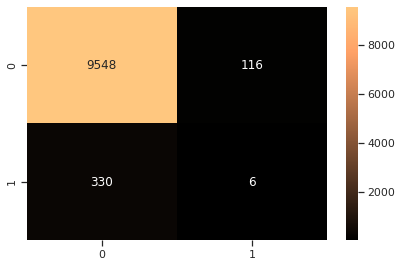

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0178571,0.987997,0.0118851




Additional Info
Total predicted to be positive: 122 

First 23 matches
23 [  6  22  42  44  52 152 163 193 197 201 219 226 253 259 279 283 291 298
 322 352 380 392 498]

[0.50080395 0.50334287 0.5052871  0.5025526  0.50145906 0.50012857
 0.5027822  0.5054151  0.5028476  0.5026786  0.5015116  0.50095034
 0.50019866 0.50203264 0.5010221  0.5063149  0.5008269  0.5005599
 0.5006754  0.50294393 0.5028974  0.5049916  0.5015267 ]


Top 23 Probable Matches

[1597  594 2958   42 5301 1531 4060 2479 5311 4609 2107 1949 3105 1047
  392 1271 1207 1553  283 1702 3576  193 7181]


[0.50449854 0.5045001  0.5048205  0.5052871  0.5084969  0.5076182
 0.505373   0.5093117  0.51060724 0.5060254  0.50597495 0.51323
 0.5053036  0.5102036  0.5049916  0.5059752  0.5057163  0.5076201
 0.5063149  0.5054221  0.5052292  0.5054151  0.5069316 ]


2 To 3 Digits

43 [ 22  42  44  52 152 163 193 197 201 219 226 253 259 279 283 291 298 322
 352 380 392 498 507 540 546 559 567 581 594 604 628 722 731 732 789 838
 851 

In [48]:
weight=1.0
decrement = 0.000
to_stop=False

dt = pd.datetime(2019,6,1)
%time gen_train_test_set(dt, feature_matrix_selection, file_prefix='test')
while not to_stop:
  to_stop = model(dt, feature_matrix_selection, file_prefix='test', class_weight=(weight-decrement))
  decrement = decrement + 0.001


2019-07-01 00:00:00
-------------------

Training on 899893 observations.
Testing on 10000 observations.

Data shape before balancing: (899893, 62)

Counts of strikes vs non-strikes in previous data:
0    869724
1     30169
Name: Label, dtype: int64
----------------------------------------

NO balancing
Data shape after balancing: (899893, 62)

Counts of strikes VS non-strikes in new data:
0    869724
1     30169
Name: Label, dtype: int64

Filtering features

Data shape before feature selection: (899893, 62)

Counts of strikes vs non-strikes before feature selection:
0    869724
1     30169
Name: Label, dtype: int64
----------------------------------------
----------------------------------------

Data shape after feature selection: (899893, 32)

Counts of strikes vs non-strikes in new data:
0    869724
1     30169
Name: Label, dtype: int64

-----------2019-07-01 00:00:00-----------------

Data shape
(899893, 31) (899893,) (10000, 31) (10000,)

Calculating scale pos weight
Counter({0:

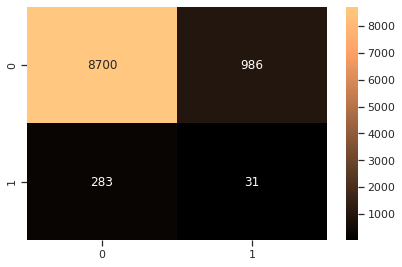

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0987261,0.898204,0.0586216




Additional Info
Total predicted to be positive: 1017 

First 23 matches
23 [ 0  5  9 13 17 18 28 29 33 35 38 42 45 50 52 54 62 64 66 67 72 73 77]

[0.50629705 0.5043603  0.50260824 0.5016583  0.5032644  0.5081183
 0.5073478  0.5027415  0.5072947  0.5144288  0.5043419  0.50598544
 0.5051688  0.5002384  0.5079608  0.5018621  0.50182307 0.50171655
 0.50216424 0.50152576 0.5051814  0.5003338  0.50219536]


Top 23 Probable Matches

[ 594  193  817 5311  823 3591   35 5301  851  895  903 1271  905  581
  661  950 1949 2479  592  298  479 6114  210]


[0.51199836 0.5157651  0.5141168  0.5156203  0.51427156 0.51507765
 0.5144288  0.51325536 0.5125559  0.51364636 0.5189871  0.5166403
 0.5169881  0.5121261  0.5148447  0.51356447 0.5131091  0.5140965
 0.5158624  0.51328874 0.5136101  0.51473165 0.5137958 ]


2 To 3 Digits

291 [ 13  17  18  28  29  33  35  38  42  45  50  52  54  62  64  66  67  72
  73  77  83  90  92 102 104 107 108 111 113 115 116 121 130 131 139 146
 148 151 152 157 163 171

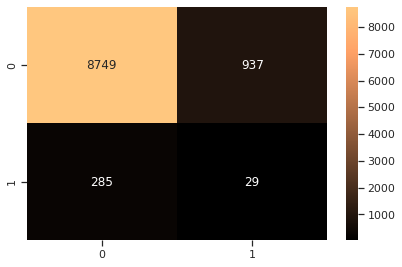

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0923567,0.903262,0.0545378




Additional Info
Total predicted to be positive: 966 

First 23 matches
23 [ 0  5  9 13 17 18 28 29 33 35 38 42 45 50 52 54 62 64 66 67 72 73 77]

[0.5060782  0.5041417  0.50238883 0.5014397  0.5030449  0.5079002
 0.5071292  0.502523   0.5070759  0.5142106  0.504125   0.5057679
 0.5049499  0.5000197  0.50774145 0.50164884 0.5016037  0.5014971
 0.50194484 0.50130683 0.5049625  0.50011647 0.50197613]


Top 23 Probable Matches

[ 581  851  298  950  479 5378  895  210   35  592 6114  903  817 1949
  193  823 2479  661 1271 3591 5311  905 5301]


[0.51190734 0.5123368  0.5130697  0.51334596 0.51339114 0.51338184
 0.51342726 0.51357704 0.5142106  0.5176548  0.51652396 0.5187683
 0.51389825 0.51489973 0.51554626 0.51605994 0.51588005 0.51462615
 0.5164224  0.51686966 0.51741177 0.51877695 0.51504624]


2 To 3 Digits

281 [ 13  17  18  28  29  33  35  38  42  45  50  52  54  62  64  66  67  72
  73  77  83  90  92 102 104 107 108 111 113 115 116 121 130 131 139 146
 151 152 157 163 171 173 1

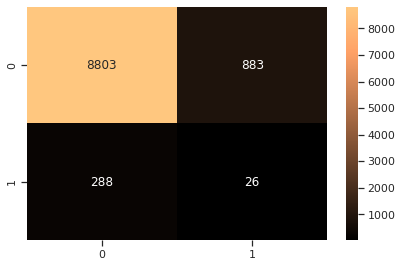

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0828025,0.908837,0.0480095




Additional Info
Total predicted to be positive: 909 

First 23 matches
23 [ 0  5  9 13 17 18 28 29 33 35 38 42 45 52 54 62 64 66 67 72 77 83 90]

[0.50585926 0.50392294 0.5021694  0.501221   0.5028253  0.507682
 0.5069104  0.5023042  0.5068569  0.51399213 0.5039078  0.5055502
 0.5047307  0.5075225  0.50143534 0.5013843  0.5012772  0.50172555
 0.50108784 0.5047437  0.50175655 0.5011408  0.5037652 ]


Top 23 Probable Matches

[ 581  851  479 5378  298  950  895   35 5301 5311  817 1271  592 1949
 6114  823  905  661  903 2479  193  210 3591]


[0.5116883  0.51211756 0.51317245 0.513172   0.51285076 0.5131308
 0.51320827 0.51399213 0.51483464 0.51720023 0.5136793  0.516208
 0.51744497 0.5146872  0.5163115  0.515846   0.51856273 0.51440734
 0.51854944 0.5156633  0.51532716 0.513358   0.5166592 ]


2 To 3 Digits

275 [ 13  17  18  28  29  33  35  38  42  45  52  54  62  64  66  67  72  77
  83  90  92 102 104 107 108 111 113 115 116 121 130 131 139 146 151 152
 157 163 171 173 175 186 191

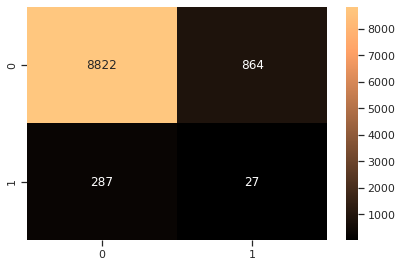

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0859873,0.910799,0.0509496




Additional Info
Total predicted to be positive: 891 

First 23 matches
23 [ 0  5  9 13 17 18 28 29 33 35 38 42 45 52 54 62 64 66 67 72 77 83 90]

[0.505778   0.5039661  0.5020683  0.5012614  0.50277144 0.50757426
 0.50692594 0.50225043 0.50687253 0.51388276 0.5037778  0.5055898
 0.50477237 0.50756127 0.50133306 0.50142485 0.50124174 0.50165707
 0.5011032  0.5047569  0.5015985  0.5005948  0.5038055 ]


Top 23 Probable Matches

[ 581 5301 5378 1949  210  895   35  479  950 2479  817  298  823  851
 5311  592 6114  661  193 1271 3591  905  903]


[0.51158196 0.51203537 0.51194847 0.5121295  0.51339847 0.51324767
 0.51388276 0.51309603 0.5133676  0.51340246 0.5134834  0.51277596
 0.5135212  0.5121579  0.5142773  0.51452816 0.51508546 0.51433384
 0.51522076 0.51469225 0.51474905 0.51649714 0.518681  ]


2 To 3 Digits

275 [ 13  17  18  28  29  33  35  38  42  45  52  54  62  64  66  67  72  77
  83  90  92 102 104 107 108 111 113 115 116 121 130 131 139 146 151 152
 157 163 171 173 175 18

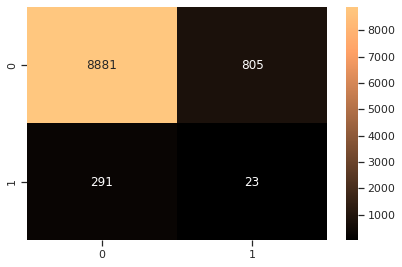

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0732484,0.91689,0.0419768




Additional Info
Total predicted to be positive: 828 

First 23 matches
23 [ 0  5  9 13 17 18 28 29 33 35 38 42 45 52 54 62 64 66 67 72 77 83 90]

[0.50542045 0.5034846  0.5017295  0.5007826  0.5023853  0.50724465
 0.5064715  0.5018659  0.50641793 0.5135542  0.50347245 0.50511396
 0.50429136 0.50708276 0.501007   0.5009445  0.50083715 0.5012859
 0.50064874 0.50430465 0.5013169  0.500758   0.5033253 ]


Top 23 Probable Matches

[ 581  851  298  817  823 5378   35 3591 1949  895  903  905  592  479
 1271 5311  661  210  950 2479 5301 6114  193]


[0.51124924 0.5116783  0.5124118  0.5132404  0.5154181  0.5127528
 0.5135542  0.51623833 0.5142617  0.51276886 0.5181107  0.5181349
 0.51702535 0.5127334  0.5157791  0.5167773  0.513969   0.5129188
 0.5127013  0.51523066 0.5144123  0.51588726 0.514888  ]


2 To 3 Digits

256 [ 13  17  18  28  29  33  35  38  42  45  52  54  62  64  66  67  72  77
  83  90  92 102 104 107 108 111 113 115 116 121 131 146 151 152 157 163
 171 173 175 186 191 192 1

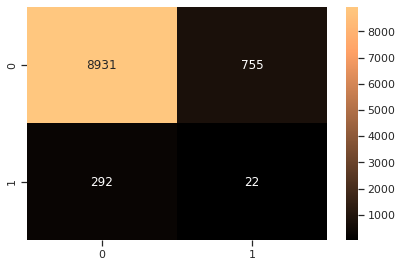

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0700637,0.922052,0.0404614




Additional Info
Total predicted to be positive: 777 

First 23 matches
23 [ 0  5  9 13 17 18 28 29 33 35 38 42 45 52 54 62 64 66 67 72 77 83 90]

[0.50520074 0.50326514 0.50150925 0.50056314 0.50216496 0.5070257
 0.5062519  0.50164646 0.50619817 0.5133351  0.5032546  0.50489557
 0.50407135 0.5068625  0.50079274 0.5007243  0.50061685 0.5010658
 0.5004289  0.5040849  0.5010968  0.5005445  0.503105  ]


Top 23 Probable Matches

[ 581  851  298  817  823 5378   35 3591 1949  895  903  905  592  479
 1271 5311  661  210  950 2479 5301 6114  193]


[0.5110295  0.5114583  0.512192   0.51302075 0.5152042  0.5125432
 0.5133351  0.5160278  0.5140491  0.51254886 0.51789105 0.517921
 0.51681566 0.51251364 0.5155647  0.5165659  0.5137496  0.512699
 0.5124865  0.51501423 0.5142011  0.5156751  0.51466817]


2 To 3 Digits

247 [ 13  17  18  28  29  33  35  38  42  45  52  54  62  64  66  67  72  77
  83  90  92 102 104 107 108 111 113 115 116 121 131 146 151 152 157 163
 171 173 175 191 192 193 197 

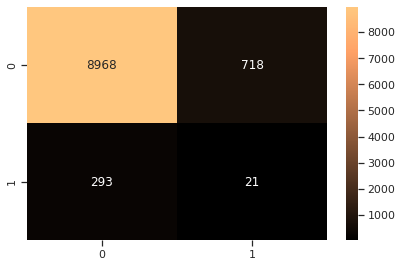

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.066879,0.925872,0.0386777




Additional Info
Total predicted to be positive: 739 

First 23 matches
23 [  0   5   9  17  18  28  29  33  35  38  42  45  52  64  66  72  77  90
  92 102 104 107 108]

[0.5052251  0.5025556  0.5008609  0.50171185 0.50611216 0.50534403
 0.50184494 0.5044233  0.51161546 0.5021777  0.5043323  0.50293887
 0.5061455  0.5007968  0.50005907 0.5002918  0.50118935 0.5026364
 0.5016406  0.5058507  0.50400674 0.50113773 0.50079733]


Top 23 Probable Matches

[ 594  851 5301  823  298   35  479 1949  210 2479  950 5378  661  592
  193 6114 5311  817  895 1271  903  905 3591]


[0.51094526 0.511458   0.5114161  0.5117119  0.51150995 0.51161546
 0.51185113 0.5125059  0.512243   0.5119979  0.5119368  0.512517
 0.5130756  0.5164355  0.51441586 0.51395744 0.5163077  0.5128138
 0.51303446 0.51508105 0.5184793  0.5150533  0.51318616]


2 To 3 Digits

229 [ 17  18  28  29  33  35  38  42  45  52  64  66  72  77  90  92 102 104
 107 108 111 113 115 121 131 146 151 152 157 163 175 192 193 197 198 201
 2

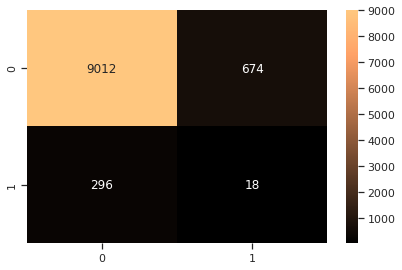

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0573248,0.930415,0.0319429




Additional Info
Total predicted to be positive: 692 

First 23 matches
23 [  0   5   9  17  18  28  29  33  35  38  42  45  52  64  72  77  90  92
 102 104 107 108 111]

[0.50500643 0.5023374  0.50064206 0.50149304 0.50589514 0.50512606
 0.5016265  0.50420576 0.5113983  0.50196165 0.50411534 0.5027205
 0.50592756 0.50057644 0.5000742  0.5009703  0.5024181  0.5014229
 0.5056343  0.50378823 0.5009187  0.5005791  0.503837  ]


Top 23 Probable Matches

[ 594 5301  479 6114 2479 3591  661  950   35 1271  905  817 1949  823
  592  851  298 5311 5378  193  895  903  210]


[0.51072717 0.5112041  0.51163405 0.5137452  0.51178163 0.51297563
 0.5128598  0.5117193  0.5113983  0.5148647  0.51483655 0.5125965
 0.51229435 0.5114957  0.51622427 0.5112391  0.51129246 0.51609707
 0.5123077  0.514198   0.5128163  0.51826185 0.5120252 ]


2 To 3 Digits

222 [ 17  18  28  29  33  35  38  42  45  52  64  72  77  90  92 102 104 107
 108 111 113 115 121 131 146 151 152 157 163 175 192 193 197 198 201 203
 

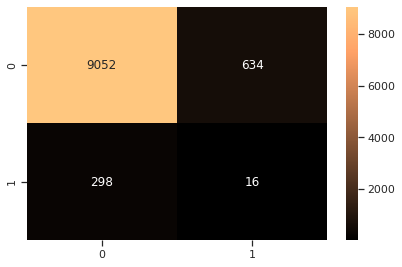

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0509554,0.934545,0.0276733




Additional Info
Total predicted to be positive: 650 

First 23 matches
23 [  0   5   9  17  18  28  29  33  35  38  42  45  52  64  77  90  92 102
 104 107 108 111 113]

[0.5047859  0.5021172  0.50042117 0.501272   0.5056753  0.5049054
 0.5014063  0.50398505 0.511178   0.5017426  0.5038962  0.5024998
 0.50570667 0.50035536 0.5007494  0.5021971  0.5012029  0.5054136
 0.503568   0.50069785 0.5003585  0.5036162  0.5053224 ]


Top 23 Probable Matches

[ 594 5301  479 6114 2479 3591  661  950   35 1271  905  817 1949  823
  592  851  298 5311 5378  193  895  903  210]


[0.51050675 0.51099163 0.5114136  0.51353204 0.511564   0.5127641
 0.51263946 0.51150316 0.511178   0.5146486  0.51462144 0.5123758
 0.5120804  0.5112808  0.51601344 0.5110184  0.5110719  0.5158847
 0.5120974  0.5139773  0.5125956  0.5180414  0.5118044 ]


2 To 3 Digits

215 [ 17  18  28  29  33  35  38  42  45  52  64  77  90  92 102 104 107 108
 111 113 115 121 131 146 151 152 157 163 175 192 193 197 198 201 203 210
 215

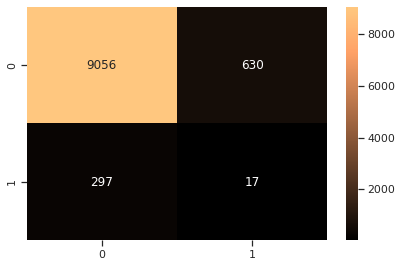

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0541401,0.934958,0.0303036




Additional Info
Total predicted to be positive: 647 

First 23 matches
23 [  0   5   9  13  17  18  28  29  33  35  38  42  45  52  62  66  67  72
  77  90  92 102 104]

[0.50462097 0.5025246  0.50084263 0.50054884 0.50143635 0.5058016
 0.50565714 0.50092316 0.50545365 0.5124955  0.5024451  0.5039988
 0.50340384 0.5059349  0.5008416  0.5003874  0.5005636  0.5013137
 0.5004518  0.5031955  0.5037543  0.50739545 0.50318724]


Top 23 Probable Matches

[ 581  851  950  823  479 1271  817   35  592  193 6114 2479  661 5301
 5311 5378 3591  905  903  895  298 1949  210]


[0.51004374 0.5104871  0.51059586 0.5113309  0.5126544  0.5149765
 0.5119959  0.5124955  0.5164775  0.5138487  0.51303166 0.5115943
 0.5142145  0.5121651  0.51635665 0.5115955  0.5131792  0.51479757
 0.5173975  0.5118593  0.51251006 0.5117404  0.5118471 ]


2 To 3 Digits

225 [ 13  17  18  28  29  33  35  38  42  45  52  62  66  67  72  77  90  92
 102 104 107 108 111 113 115 121 131 139 146 151 152 157 163 175 191 192
 19

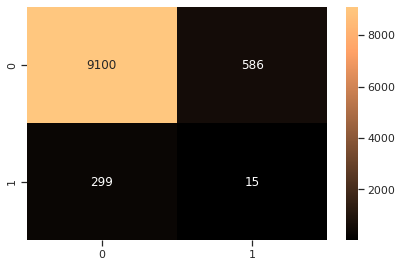

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0477707,0.9395,0.0261166




Additional Info
Total predicted to be positive: 601 

First 23 matches
23 [  0   5   9  13  17  18  28  29  33  35  38  42  45  52  62  66  67  72
  77  90  92 102 104]

[0.5044002  0.502304   0.50062126 0.5003282  0.50121486 0.5055816
 0.5054363  0.50070256 0.50523275 0.5122753  0.5022261  0.50377935
 0.50318277 0.5057135  0.5006202  0.50016606 0.5003426  0.50109327
 0.5002306  0.50297403 0.5035337  0.5071748  0.5029666 ]


Top 23 Probable Matches

[ 581  851  950  823  479 1271  817   35  592  193 6114 2479  661 5301
 5311 5378 3591  905  903  895  298 1949  210]


[0.5098228  0.510266   0.51038    0.5111162  0.5124334  0.514761
 0.51177514 0.5122753  0.5162674  0.5136277  0.5128185  0.5113768
 0.5139939  0.51195306 0.5161449  0.51138526 0.51296765 0.51458263
 0.5171767  0.5116381  0.51228905 0.5115268  0.5116261 ]


2 To 3 Digits

214 [ 13  17  18  28  29  33  35  38  42  45  52  62  66  67  72  77  90  92
 102 104 108 111 113 115 121 131 146 151 152 157 163 175 192 193 197 198
 2

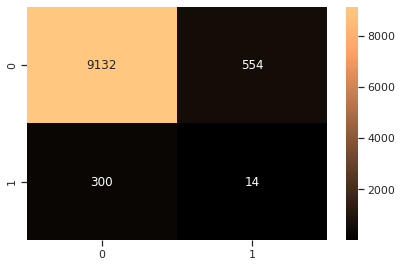

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.044586,0.942804,0.0242296




Additional Info
Total predicted to be positive: 568 

First 23 matches
23 [  0   5   9  13  17  18  28  29  33  35  38  42  45  52  62  67  72  90
  92 102 104 108 111]

[0.5041933  0.502044   0.5004142  0.50006765 0.5010075  0.50532174
 0.50517607 0.5004421  0.5049731  0.51201564 0.5019678  0.5035734
 0.5029216  0.5055058  0.5003592  0.5000822  0.5008867  0.50276685
 0.5033268  0.50691533 0.50276    0.500236   0.5047531 ]


Top 23 Probable Matches

[ 581  851  823  950 2479  895  661   35 5378 6114  210 3591 1271 5301
  298  592 5311  193  817  905  903 1949  479]


[0.5096166  0.5100586  0.510901   0.51017725 0.5111587  0.51143014
 0.51373494 0.51201564 0.5111746  0.51260495 0.5114204  0.5127555
 0.51455885 0.5117406  0.51208365 0.5160562  0.5159325  0.5133672
 0.51151544 0.51436716 0.5169696  0.51131254 0.5122267 ]


2 To 3 Digits

207 [ 13  17  18  28  29  33  35  38  42  45  52  62  67  72  90  92 102 104
 108 111 113 115 121 131 146 151 152 157 163 175 192 193 197 198 201 203
 

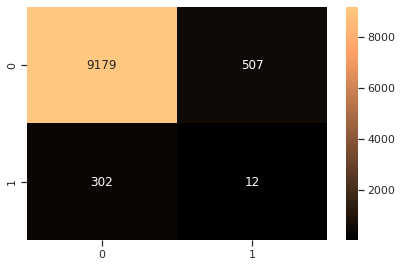

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0382166,0.947656,0.0201045




Additional Info
Total predicted to be positive: 519 

First 23 matches
23 [  0   5   9  17  18  28  29  33  35  38  42  45  52  62  72  90  92 102
 104 108 111 113 115]

[0.5039721  0.50182307 0.5001924  0.5007857  0.50510126 0.5049549
 0.50022113 0.50475186 0.511795   0.50174844 0.50335354 0.5027001
 0.5052841  0.5001374  0.50066584 0.50254494 0.50310576 0.5066943
 0.50253904 0.50001454 0.5045318  0.5051286  0.5023476 ]


Top 23 Probable Matches

[ 581  851  823  950 2479  895  661   35 5378 6114  210 3591 1271 5301
  298  592 5311  193  817  905  903 1949  479]


[0.5093953  0.5098371  0.510686   0.50996107 0.51094085 0.5112086
 0.5135139  0.511795   0.5109644  0.5123918  0.5111991  0.5125446
 0.5143429  0.5115282  0.5118622  0.51584566 0.5157207  0.5131458
 0.5112943  0.5141518  0.51674837 0.5110986  0.51200527]


2 To 3 Digits

195 [ 17  18  28  29  33  35  38  42  45  52  62  72  90  92 102 104 108 111
 113 115 121 131 146 151 152 157 163 192 193 197 198 201 203 210 215 216
 219

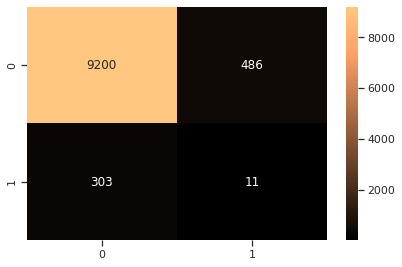

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0350318,0.949824,0.0179904




Additional Info
Total predicted to be positive: 497 

First 23 matches
23 [  0   5  17  18  28  33  35  38  42  45  52  72  90  92 102 104 111 113
 115 121 131 146 151]

[0.5037507  0.5016019  0.50056356 0.5048806  0.5047334  0.50453025
 0.511574   0.5015288  0.50313336 0.50247836 0.50506204 0.5004447
 0.50232273 0.50288445 0.506473   0.5023177  0.5043102  0.5049075
 0.5021281  0.5008545  0.5049572  0.50097126 0.50445086]


Top 23 Probable Matches

[ 581  851  950  823 2479 5378 1949  210  895   35  661  479  903  298
  817 5301  592 5311 1271 6114 3591  905  193]


[0.5091737  0.5096153  0.5097445  0.5104706  0.5107227  0.5107535
 0.51088446 0.51097757 0.5109867  0.511574   0.51329255 0.51178354
 0.5165269  0.51164055 0.5110729  0.51131546 0.5156349  0.5155083
 0.5141267  0.512178   0.5123324  0.51393616 0.512924  ]


2 To 3 Digits

187 [ 17  18  28  33  35  38  42  45  52  72  90  92 102 104 111 113 115 121
 131 146 151 152 157 163 192 193 197 198 201 203 210 215 216 219 226 230
 2

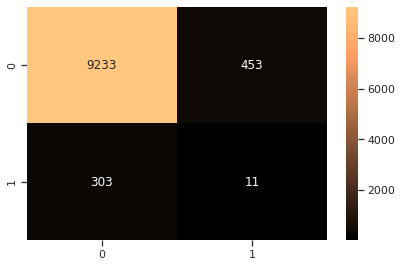

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0350318,0.953231,0.0186718




Additional Info
Total predicted to be positive: 464 

First 23 matches
23 [  0   5  17  18  28  33  35  38  42  45  52  72  90  92 102 104 111 113
 115 121 131 146 151]

[0.50352526 0.5014301  0.5003375  0.50470936 0.5045611  0.50435674
 0.5114012  0.5013582  0.50290954 0.50230676 0.504837   0.50021946
 0.5020966  0.5026592  0.50629973 0.5020925  0.5041376  0.5047355
 0.5019567  0.5006287  0.5047832  0.50079954 0.50422573]


Top 23 Probable Matches

[ 581  851  193  895 1271  823  817   35  210  903 6114 5301  905 1949
  661 3591 2479 5311  950  592  479  298 5378]


[0.5089474  0.50938976 0.5127516  0.5107625  0.5138947  0.51225716
 0.51090026 0.5114012  0.51075053 0.5163022  0.5139676  0.51310325
 0.51572186 0.51267266 0.512987   0.5141202  0.5125045  0.5172961
 0.5095138  0.5174248  0.51142526 0.5112809  0.5125421 ]


2 To 3 Digits

183 [ 17  18  28  33  35  38  42  45  52  72  90  92 102 104 111 113 115 121
 131 146 151 157 163 192 193 197 198 201 210 215 216 219 226 230 243 244


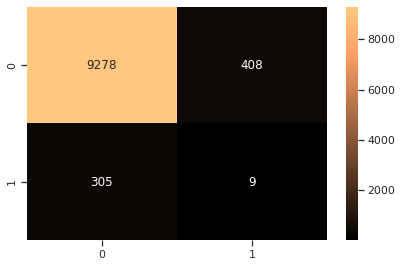

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0286624,0.957877,0.0145054




Additional Info
Total predicted to be positive: 417 

First 23 matches
23 [  0   5  18  28  33  35  38  42  45  52  90 102 104 111 113 115 131 151
 192 193 197 198 201]

[0.5032349  0.500654   0.5041297  0.50343835 0.5025165  0.50971395
 0.5002874  0.5023547  0.5010327  0.5041524  0.5006431  0.5039483
 0.5020188  0.50214857 0.5038575  0.5000859  0.5039973  0.5034147
 0.5007961  0.51250875 0.50875825 0.50011635 0.5047574 ]


Top 23 Probable Matches

[ 594  851  298   35  479  950  210  817  661  823 2479  193 5301  895
 1949 1271  903 5311 5378 6114 3591  592  905]


[0.5089576  0.5094669  0.5095196  0.50971395 0.5098618  0.50998336
 0.5102522  0.5109093  0.5111749  0.51177216 0.5120348  0.51250875
 0.51150006 0.51104236 0.5125812  0.5131328  0.51649    0.51639587
 0.51261836 0.5140366  0.51357996 0.51653624 0.51511   ]


2 To 3 Digits

157 [ 18  28  33  35  38  42  45  52  90 102 104 111 113 115 131 151 192 193
 197 198 201 210 215 216 219 230 243 244 249 253 259 272 278 279 282 283


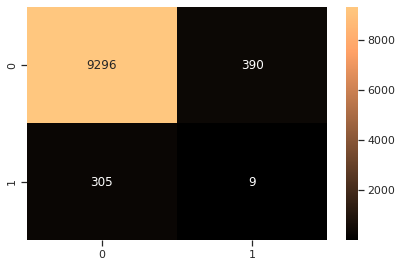

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0286624,0.959736,0.0148771




Additional Info
Total predicted to be positive: 399 

First 23 matches
23 [  0   5  18  28  33  35  38  42  45  52  90 102 104 111 113 131 151 192
 193 197 201 210 215]

[0.50301284 0.5004322  0.50390834 0.5032161  0.50229424 0.5094922
 0.50006694 0.5021339  0.5008104  0.50392973 0.50042045 0.5037263
 0.5017968  0.50192624 0.50363564 0.5037752  0.503192   0.5005756
 0.5122864  0.50853616 0.50453484 0.5100299  0.50180304]


Top 23 Probable Matches

[ 594  851  298   35  479  950  210  817  661  823 2479  193 5301  895
 1949 1271  903 5311 5378 6114 3591  592  905]


[0.5087356  0.50924444 0.5092974  0.5094922  0.5096396  0.509766
 0.5100299  0.51068723 0.510953   0.5115559  0.51181567 0.5122864
 0.5112865  0.5108198  0.5123661  0.512916   0.5162677  0.5161826
 0.5124067  0.513822   0.5133669  0.5163245  0.5148935 ]


2 To 3 Digits

153 [ 18  28  33  35  38  42  45  52  90 102 104 111 113 131 151 192 193 197
 201 210 215 216 219 230 243 244 249 253 259 272 278 279 282 283 291 294
 298 

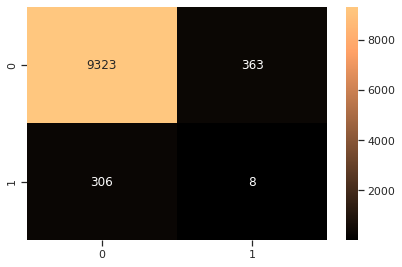

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0254777,0.962523,0.0128868




Additional Info
Total predicted to be positive: 371 

First 23 matches
23 [  0   5  18  28  33  35  42  45  52  90 102 104 111 113 131 151 192 193
 197 201 210 215 216]

[0.50279045 0.50021017 0.5036868  0.5029935  0.50207174 0.50927025
 0.5019129  0.5005879  0.50370693 0.5001975  0.5035041  0.50157464
 0.5017037  0.5034135  0.5035528  0.5029691  0.5003549  0.5120638
 0.5083138  0.50431204 0.50980747 0.5015802  0.50704324]


Top 23 Probable Matches

[ 594  851  298   35  479 1949 5301 6114  210 1271  817  823 5311 2479
  592  950  193 3591  905  903 5378  895  661]


[0.50851333 0.50902176 0.5090749  0.50927025 0.5094172  0.5121508
 0.51107264 0.5136072  0.50980747 0.51269895 0.5104649  0.5113394
 0.5159691  0.51159644 0.5161126  0.5095485  0.5120638  0.5131536
 0.5146767  0.5160453  0.5121949  0.51059705 0.510731  ]


2 To 3 Digits

148 [ 18  28  33  35  42  45  52  90 102 104 111 113 131 151 192 193 197 201
 210 215 216 219 230 243 244 249 253 259 272 278 279 282 283 291 294 298
 3

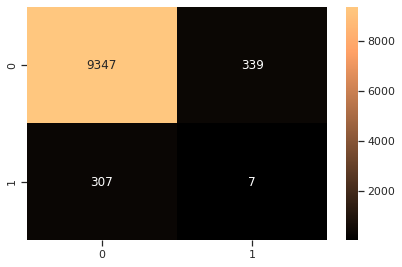

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.022293,0.965001,0.0108346




Additional Info
Total predicted to be positive: 346 

First 23 matches
23 [  0  18  28  33  35  42  45  52 102 104 111 113 131 151 192 193 197 201
 210 215 216 219 230]

[0.5025677  0.50346607 0.50277174 0.50184935 0.5090489  0.5016919
 0.5003651  0.50348395 0.50328267 0.50135183 0.50148016 0.5031921
 0.5033314  0.50274616 0.5001346  0.51184154 0.5080921  0.5040889
 0.50958526 0.5013561  0.50682247 0.50453585 0.5009622 ]


Top 23 Probable Matches

[ 594  851  298   35  950  479  210  903  817 5311 5301  823  895  193
  592 2479 5378  905 3591 1949 6114 1271  661]


[0.50829136 0.5087992  0.5088523  0.5090489  0.5093298  0.5091948
 0.50958526 0.51582295 0.5102443  0.5157538  0.5108574  0.5111217
 0.5103743  0.51184154 0.515899   0.5113758  0.5119813  0.51445824
 0.51293826 0.51193386 0.5133907  0.51248085 0.5105082 ]


2 To 3 Digits

138 [ 18  28  33  35  42  45  52 102 104 111 113 131 151 192 193 197 201 210
 215 216 219 230 243 244 249 253 259 272 278 279 282 283 291 294 298 314
 31

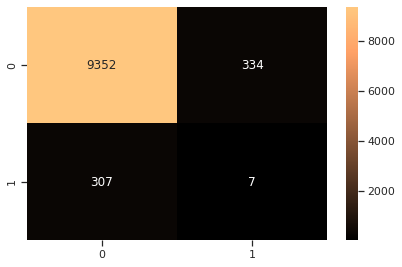

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.022293,0.965517,0.0109378




Additional Info
Total predicted to be positive: 341 

First 23 matches
23 [  0   5  18  28  33  35  38  42  45  52  72  90  92 102 104 111 113 115
 131 151 193 197 201]

[0.5018191  0.50036794 0.50399715 0.50365883 0.50331914 0.51018107
 0.50047296 0.50185126 0.50124437 0.5038924  0.50126356 0.5008747
 0.50147    0.5050623  0.50063795 0.5014111  0.5039012  0.50058
 0.5034026  0.5032611  0.51156884 0.50751114 0.5056577 ]


Top 23 Probable Matches

[ 594  851  950  298 1271  592  895   35  903  905  210 5301 5311  479
  193 5378  823  817 3591  661 6114 2479 1949]


[0.50787145 0.5083202  0.50873095 0.51013863 0.5137015  0.51342124
 0.5095509  0.51018107 0.5150168  0.51450473 0.50951827 0.512136
 0.5146238  0.5104216  0.51156884 0.5088165  0.51081336 0.5100599
 0.5098038  0.51177174 0.5132746  0.5112608  0.51093847]


2 To 3 Digits

147 [ 18  28  33  35  38  42  45  52  72  90  92 102 104 111 113 115 131 151
 193 197 201 210 215 216 219 230 243 244 249 253 259 271 272 278 279 282
 283 

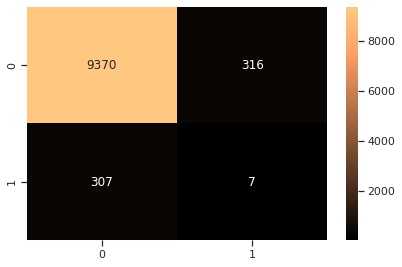

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.022293,0.967376,0.0113095




Additional Info
Total predicted to be positive: 323 

First 23 matches
23 [  0   5  18  28  33  35  38  42  45  52  72  90  92 102 104 111 113 115
 131 151 193 197 201]

[0.50159496 0.5001441  0.5037755  0.50343657 0.5030969  0.50995946
 0.50025266 0.5016291  0.50102055 0.5036691  0.50104076 0.5006505
 0.5012472  0.50484115 0.500414   0.50118786 0.5036791  0.50036025
 0.5031814  0.5030374  0.5113459  0.5072884  0.5054331 ]


Top 23 Probable Matches

[ 581 5378  210  851  594 3591  895  817   35 2479  298  479  823 1949
 6114 5301 5311  592  193  905  903 1271  661]


[0.5075409  0.5087231  0.5092955  0.5080962  0.5076486  0.50970864
 0.5093272  0.5098388  0.50995946 0.5110243  0.5099157  0.51019895
 0.5105774  0.5111629  0.5131783  0.5120453  0.51499146 0.5119421
 0.5113459  0.51441383 0.5147942  0.51407045 0.5115489 ]


2 To 3 Digits

140 [ 18  28  33  35  38  42  45  52  72  90  92 102 104 111 113 115 131 151
 193 197 201 210 215 216 219 230 243 244 249 253 259 272 278 279 282 283


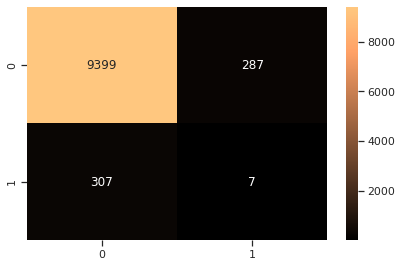

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.022293,0.97037,0.0119083




Additional Info
Total predicted to be positive: 294 

First 23 matches
23 [  0   5  18  28  33  35  42  45  52  72  90  92 102 104 111 113 115 131
 151 193 197 201 210]

[0.5014058  0.50003046 0.50343484 0.503018   0.50267506 0.5098191
 0.5014455  0.5006818  0.5032372  0.50052565 0.5005193  0.5008293
 0.5047018  0.5003287  0.50130206 0.50333744 0.5001406  0.50304383
 0.5026033  0.51101065 0.5069514  0.5047879  0.5089565 ]


Top 23 Probable Matches

[ 581  594  210  851  895  817 5378  479  298   35  823  661 6114 5301
  592  903  905 2479 3591 1949 5311  193 1271]


[0.5072037  0.5072292  0.5089565  0.50798494 0.5089184  0.5094997
 0.5085503  0.509987   0.5095774  0.5098191  0.5104849  0.51122594
 0.51302433 0.5115701  0.51121247 0.5143846  0.51392424 0.5109594
 0.5113975  0.5111265  0.51481205 0.51101065 0.5133944 ]


2 To 3 Digits

130 [ 18  28  33  35  42  45  52  72  90  92 102 104 111 113 115 131 151 193
 197 201 210 216 219 230 243 244 253 259 272 278 279 282 283 291 298 314
 3

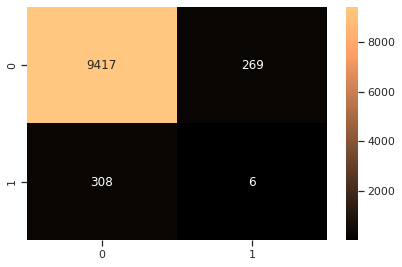

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0191083,0.972228,0.00973222




Additional Info
Total predicted to be positive: 275 

First 23 matches
23 [  0  18  28  33  35  42  45  52  72  90  92 102 104 111 113 131 151 193
 197 201 210 216 219]

[0.50118226 0.50321203 0.5027945  0.5024514  0.50959605 0.50122327
 0.500458   0.50301313 0.500302   0.5002951  0.50060594 0.50447845
 0.5001054  0.5010785  0.5031143  0.5028202  0.5023792  0.51078683
 0.50672793 0.50456387 0.5087328  0.506003   0.5038119 ]


Top 23 Probable Matches

[ 581  594  210  851  895  817 5378  479  298   35  823  661 6114 5301
  592  903  905 2479 3591 1949 5311  193 1271]


[0.50697994 0.50700575 0.5087328  0.507761   0.5086944  0.5092762
 0.50833654 0.5097632  0.50935364 0.50959605 0.51026726 0.51100254
 0.5128083  0.51135504 0.5109986  0.5141609  0.5137063  0.51073897
 0.5111838  0.51091015 0.5145971  0.51078683 0.5131763 ]


2 To 3 Digits

124 [ 18  28  33  35  42  45  52  72  90  92 102 104 111 113 131 151 193 197
 201 210 216 219 230 243 244 253 259 272 278 279 282 283 291 298 314 316

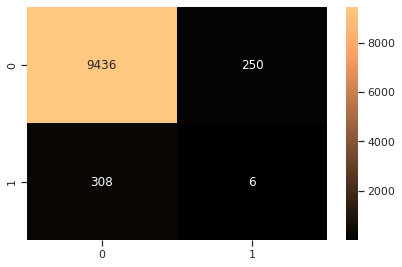

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0191083,0.97419,0.0101245




Additional Info
Total predicted to be positive: 256 

First 23 matches
23 [  0  18  28  33  35  42  45  52  72  90  92 102 111 113 131 151 193 197
 201 210 216 219 230]

[0.50095856 0.50298905 0.50257075 0.5022276  0.5093727  0.50100076
 0.50023395 0.50278884 0.50007814 0.50007063 0.5003823  0.50425476
 0.5008547  0.50289094 0.5025963  0.5021548  0.5105628  0.5065041
 0.50433946 0.50850886 0.50577986 0.5035876  0.5002192 ]


Top 23 Probable Matches

[ 581  594  210  851  895  817 5378  479  298   35  823  661 6114 5301
  592  903  905 2479 3591 1949 5311  193 1271]


[0.506756   0.50678205 0.50850886 0.50753695 0.50847024 0.50905246
 0.50812244 0.5095391  0.50912964 0.5093727  0.5100494  0.51077884
 0.51259214 0.5111398  0.5107844  0.513937   0.5134882  0.5105183
 0.5109698  0.5106936  0.5143819  0.5105628  0.512958  ]


2 To 3 Digits

119 [ 18  28  33  35  42  45  52  72  90  92 102 111 113 131 151 193 197 201
 210 216 219 230 243 253 259 272 278 279 282 283 291 298 314 316 344 352


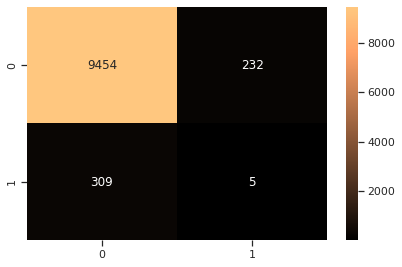

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0159236,0.976048,0.00794843




Additional Info
Total predicted to be positive: 237 

First 23 matches
23 [  0  18  28  33  35  42  45  52  92 102 111 113 131 151 193 197 201 210
 216 219 243 253 259]

[0.50073457 0.5027658  0.50234675 0.50200355 0.5091492  0.500778
 0.5000097  0.50256425 0.5001585  0.50403094 0.5006307  0.5026673
 0.5023722  0.5019303  0.5103385  0.5062802  0.50411487 0.5082846
 0.5055566  0.50336313 0.50326836 0.50081074 0.5010564 ]


Top 23 Probable Matches

[ 581  594  210  851  895  817 5378  479  298   35  823  661 6114 5301
  592  903  905 2479 3591 1949 5311  193 1271]


[0.5065318  0.5065581  0.5082846  0.50731254 0.50824577 0.50882846
 0.5079082  0.5093149  0.50890535 0.5091492  0.50983137 0.51055497
 0.51237565 0.5109244  0.51057    0.5137129  0.5132698  0.5102974
 0.51075566 0.51047677 0.5141665  0.5103385  0.5127394 ]


2 To 3 Digits

108 [ 18  28  33  35  42  45  52  92 102 111 113 131 151 193 197 201 210 216
 219 243 253 259 272 278 279 282 283 291 298 314 316 344 352 362 384 392
 41

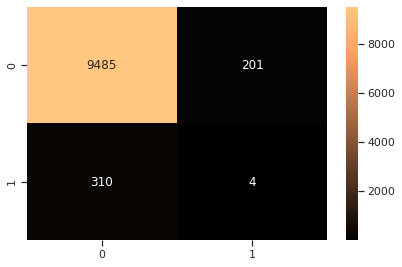

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0127389,0.979248,0.00604076




Additional Info
Total predicted to be positive: 205 

First 23 matches
23 [  0  18  28  33  35  42  52  92 102 113 131 151 193 197 201 210 216 219
 243 253 259 272 278]

[0.5005249  0.50272316 0.50220734 0.5019395  0.5088311  0.50073445
 0.5024522  0.50009686 0.50292134 0.50262326 0.50212276 0.501903
 0.5102132  0.50623554 0.50311536 0.5082372  0.505312   0.5032771
 0.5022499  0.5006995  0.5010304  0.5050951  0.50052065]


Top 23 Probable Matches

[ 581  594  823  851  950  298 1949 2479  895  479  210  592   35 1271
 6114 3591  903 5311  905 5301  661  193  817]


[0.5064809  0.50649524 0.5073775  0.50726575 0.5065193  0.5077285
 0.50844276 0.5080431  0.50819576 0.5079412  0.5082372  0.5086402
 0.5088311  0.5125409  0.51033866 0.50872034 0.5135114  0.51215744
 0.51167697 0.50873494 0.5093631  0.5102132  0.5087831 ]


2 To 3 Digits

88 [ 18  28  33  35  42  52  92 102 113 131 151 193 197 201 210 216 219 243
 253 259 272 278 282 283 291 298 314 344 352 384 392 414 421 422 430 479
 496

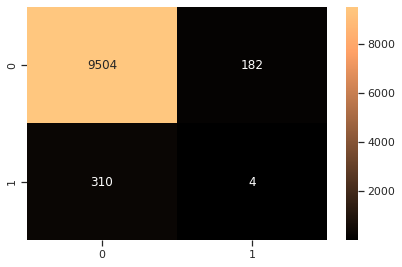

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0127389,0.98121,0.00643308




Additional Info
Total predicted to be positive: 186 

First 23 matches
23 [  0  18  28  33  35  42  52 102 113 131 151 193 197 201 210 216 219 243
 253 259 272 278 282]

[0.50030047 0.50249946 0.5019828  0.50171494 0.5086071  0.5005113
 0.5022272  0.5026971  0.50239915 0.50189817 0.50167793 0.5099884
 0.50601107 0.50289035 0.50801253 0.5050882  0.5030521  0.50202554
 0.5004744  0.50080544 0.5048706  0.50029564 0.5004203 ]


Top 23 Probable Matches

[ 581  594  823  851  950  298 1949 2479  895  479  210  592   35 1271
 6114 3591  903 5311  905 5301  661  193  817]


[0.5062562  0.5062709  0.5071591  0.50704086 0.50629973 0.5075038
 0.5082257  0.5078219  0.5079708  0.50771654 0.50801253 0.5084256
 0.5086071  0.5123218  0.51012194 0.5085059  0.51328677 0.51194173
 0.51145834 0.5085192  0.5091388  0.5099884  0.5085587 ]


2 To 3 Digits

83 [ 18  28  33  35  42  52 102 113 131 151 193 197 201 210 216 219 243 253
 259 272 278 282 283 291 298 314 352 384 392 414 421 422 430 479 496 498
 50

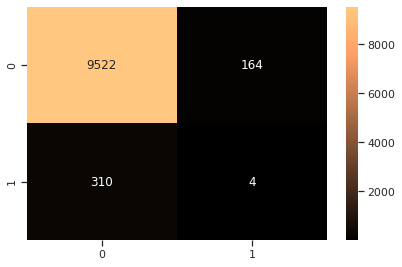

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0127389,0.983068,0.00680475




Additional Info
Total predicted to be positive: 168 

First 23 matches
23 [  0  18  28  33  35  42  52 102 113 131 151 193 197 201 210 216 219 243
 253 259 272 278 282]

[0.5000754  0.5022752  0.50175774 0.5014898  0.50838244 0.50028753
 0.5020014  0.5024722  0.50217456 0.501673   0.5014522  0.50976294
 0.5057862  0.5026648  0.50778735 0.50486404 0.5028266  0.5018009
 0.5002486  0.50057995 0.5046456  0.50007004 0.5001954 ]


Top 23 Probable Matches

[ 581  594  851  298  950 2479 1949  895 3591  479  210 5301   35  661
  817  823  592 6114 5311  903 1271  905  193]


[0.506031   0.50604594 0.5068158  0.50727874 0.50741976 0.5074474
 0.50785094 0.5077455  0.50813544 0.5074914  0.50778735 0.5081497
 0.50838244 0.5089142  0.5083336  0.50828004 0.50954014 0.50974965
 0.5115685  0.51306176 0.5119449  0.5125794  0.50976294]


2 To 3 Digits

80 [ 18  28  33  35  42  52 102 113 131 151 193 197 201 210 216 219 243 253
 259 272 278 282 283 291 298 314 384 392 414 421 422 430 479 496 498 500
 5

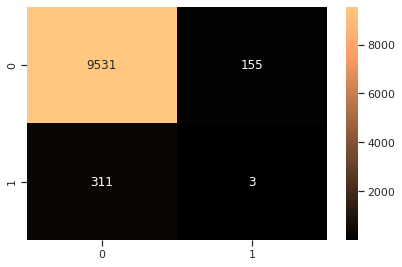

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.00955414,0.983998,0.00444282




Additional Info
Total predicted to be positive: 158 

First 23 matches
23 [ 18  28  33  35  42  52 102 113 131 151 193 197 201 210 216 219 243 253
 259 272 283 291 298]

[0.50205106 0.5015328  0.50126487 0.50815797 0.5000639  0.50177586
 0.5022475  0.50195    0.5014479  0.50122666 0.5095377  0.5055612
 0.5024394  0.50756216 0.5046398  0.50260115 0.50157607 0.50002295
 0.5003546  0.5044206  0.5052534  0.50087863 0.5070536 ]


Top 23 Probable Matches

[ 581  594  851  298  950 2479 1949  895 3591  479  210 5301   35  661
  817  823  592 6114 5311  903 1271  905  193]


[0.5058058  0.50582105 0.5065905  0.5070536  0.5071992  0.5072258
 0.50763345 0.5075201  0.50792056 0.5072663  0.50756216 0.5079335
 0.50815797 0.50868934 0.5081087  0.5080607  0.5093245  0.50953245
 0.51135236 0.5128367  0.5117254  0.5123597  0.5095377 ]


2 To 3 Digits

77 [ 18  28  33  35  42  52 102 113 131 151 193 197 201 210 216 219 243 253
 259 272 283 291 298 314 384 392 421 422 430 479 496 498 500 507 519 537
 5

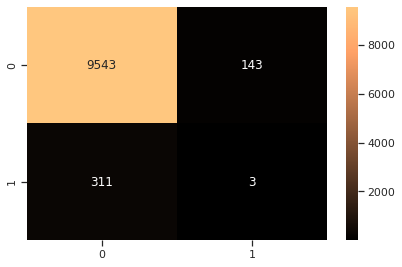

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.00955414,0.985236,0.0046906




Additional Info
Total predicted to be positive: 146 

First 23 matches
23 [ 18  28  33  35  52 102 113 131 151 193 197 201 210 216 219 243 259 272
 283 291 298 314 384]

[0.50182664 0.50130767 0.50103956 0.50793326 0.5015502  0.5020226
 0.5017253  0.50122267 0.50100094 0.5093122  0.50533605 0.5022137
 0.5073368  0.5044153  0.5023755  0.501351   0.50012904 0.5041954
 0.50502855 0.5006529  0.5068283  0.5009191  0.50060517]


Top 23 Probable Matches

[ 581  594  851  298  950  895 5301 2479  479 3591  210 1949  823  193
 5311   35 1271  592  903  817  905  661 6114]


[0.5055804  0.505596   0.50636494 0.5068283  0.50697845 0.50729454
 0.50771713 0.507004   0.50704086 0.5077055  0.5073368  0.50741565
 0.50784105 0.5093122  0.511136   0.50793326 0.5115057  0.5091086
 0.5126113  0.5078835  0.5121398  0.5084644  0.509315  ]


2 To 3 Digits

72 [ 18  28  33  35  52 102 113 131 151 193 197 201 210 216 219 243 259 272
 283 291 298 314 384 392 421 422 430 479 496 498 500 507 537 540 546 557
 56

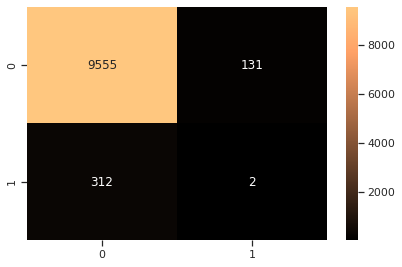

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.00636943,0.986475,0.00239061




Additional Info
Total predicted to be positive: 133 

First 23 matches
23 [ 18  28  33  35  52 102 113 131 151 193 197 201 210 216 219 243 272 283
 291 298 314 384 392]

[0.501602   0.50108224 0.50081414 0.50770825 0.50132424 0.50179744
 0.5015003  0.5009971  0.5007749  0.5090865  0.5051107  0.5019878
 0.5071112  0.5041905  0.5021496  0.5011257  0.5039699  0.5048035
 0.500427   0.50660276 0.50069344 0.5003794  0.50501764]


Top 23 Probable Matches

[ 581  594  298  851  950 3591  823   35  592 1949  817  895 5301 2479
  210  661  479  193 6114 1271  903  905 5311]


[0.5053548  0.5053707  0.50660276 0.50613916 0.5067574  0.50749016
 0.5076212  0.50770825 0.50889254 0.50719774 0.50765806 0.50706863
 0.5075005  0.506782   0.5071112  0.50823915 0.5068153  0.5090865
 0.5090974  0.5112858  0.5123857  0.5119197  0.5109194 ]


2 To 3 Digits

69 [ 18  28  33  35  52 102 113 131 151 193 197 201 210 216 219 243 272 283
 291 298 314 384 392 421 422 430 479 496 500 507 537 546 557 567 575 581
 5

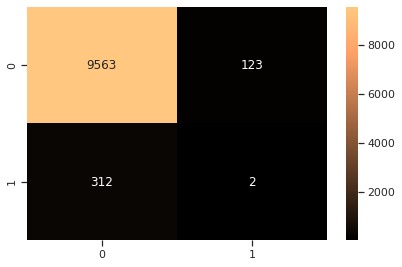

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.00636943,0.987301,0.00255579




Additional Info
Total predicted to be positive: 125 

First 23 matches
23 [ 18  28  33  35  52 102 113 131 151 193 197 201 210 216 219 243 272 283
 291 298 314 384 392]

[0.5013771  0.5008567  0.5005885  0.50748307 0.501098   0.5015721
 0.50127506 0.5007714  0.5005487  0.50886047 0.504885   0.5017617
 0.50688535 0.50396556 0.50192344 0.50090015 0.5037441  0.5045781
 0.5002008  0.50637686 0.50046754 0.50015336 0.5047923 ]


Top 23 Probable Matches

[ 581  594  298  851  950 3591  823   35  592 1949  817  895 5301 2479
  210  661  479  193 6114 1271  903  905 5311]


[0.505129   0.5051451  0.50637686 0.5059132  0.50653607 0.50727457
 0.5074011  0.50748307 0.5086762  0.50697947 0.5074324  0.5068425
 0.5072836  0.50655967 0.50688535 0.50801367 0.5065894  0.50886047
 0.5088795  0.5110656  0.5121599  0.5116993  0.51070255]


2 To 3 Digits

68 [ 18  28  33  35  52 102 113 131 151 193 197 201 210 216 219 243 272 283
 291 298 314 384 392 421 422 430 479 496 500 537 546 557 567 575 581 590
 59

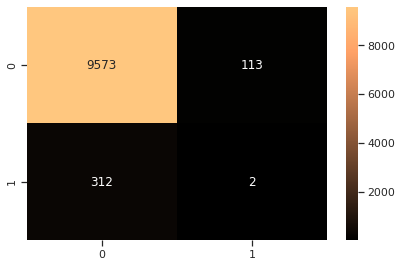

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.00636943,0.988334,0.00276228




Additional Info
Total predicted to be positive: 115 

First 23 matches
23 [ 18  28  33  35  52 102 113 131 151 193 197 201 210 216 219 243 272 283
 298 314 392 421 422]

[0.5011519  0.5006304  0.5003618  0.507257   0.50087893 0.5013463
 0.50104946 0.5005452  0.50032216 0.50863373 0.504666   0.5015426
 0.5066583  0.5037402  0.5017047  0.50067437 0.50352484 0.50435233
 0.5061499  0.5002412  0.5045665  0.50365645 0.5000312 ]


Top 23 Probable Matches

[ 581  594  298  851  950 3591  823   35  592 1949  817  895 5301 2479
  210  661  479  193 6114 1271  903  905 5311]


[0.50490254 0.50491863 0.5061499  0.50568664 0.5063143  0.5070586
 0.5071803  0.507257   0.50845945 0.50676066 0.5072062  0.5066232
 0.50706625 0.5063366  0.5066583  0.50779337 0.50636244 0.50863373
 0.5086611  0.5108453  0.5119406  0.51147825 0.5104853 ]


2 To 3 Digits

60 [ 18  28  33  35  52 102 113 131 151 193 197 201 210 216 219 243 272 283
 298 314 392 421 422 430 479 496 500 537 546 557 567 575 581 591 592 594
 59

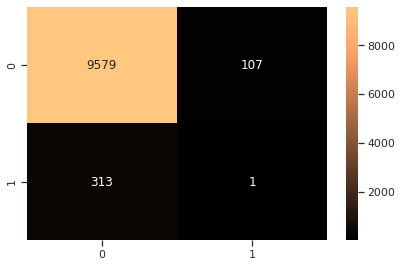

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.00318471,0.988953,0.000338396




Additional Info
Total predicted to be positive: 108 

First 23 matches
23 [ 18  28  33  35  52 102 113 131 151 193 197 201 210 216 219 243 272 283
 298 314 392 421 430]

[0.50092626 0.5004033  0.5001344  0.5070298  0.5006517  0.501119
 0.50082296 0.5003182  0.500095   0.5084067  0.5044396  0.50131536
 0.50643134 0.50351405 0.50147724 0.5004483  0.5032985  0.50412637
 0.505923   0.5000148  0.5043406  0.5034299  0.5030986 ]


Top 23 Probable Matches

[ 581  594  298  851  950 3591  823   35  592 1949  817  895 5301 2479
  210  661  479  193 6114 1271  903  905 5311]


[0.50467587 0.50469244 0.505923   0.5054601  0.5060922  0.5068386
 0.5069575  0.5070298  0.5082405  0.5065401  0.50697976 0.50639653
 0.5068458  0.5061126  0.50643134 0.507567   0.50613546 0.5084067
 0.5084402  0.51062363 0.5117141  0.5112544  0.51026446]


2 To 3 Digits

58 [ 18  28  33  35  52 102 113 131 151 193 197 201 210 216 219 243 272 283
 298 314 392 421 430 479 496 500 537 546 557 567 575 581 591 592 594 595
 61

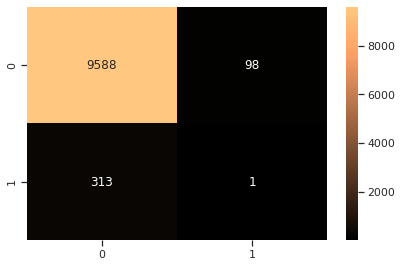

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.00318471,0.989882,0.000524232




Additional Info
Total predicted to be positive: 99 

First 23 matches
23 [ 18  28  35  52 102 113 131 193 197 201 210 216 219 243 272 283 298 392
 421 430 479 496 500]

[0.50070053 0.5001771  0.5068038  0.5004248  0.50089294 0.500597
 0.5000917  0.50818014 0.50421315 0.50108844 0.50620484 0.5032882
 0.5012503  0.50022197 0.5030719  0.50390047 0.50569624 0.50411457
 0.5032038  0.50287217 0.5059087  0.50041467 0.50127125]


Top 23 Probable Matches

[ 594  851  298 5378  950  479   35  210  661  817  895 2479 1949 3591
  592 1271 5311  823 5301  903  905  193 6114]


[0.5044662  0.5052333  0.50569624 0.50579333 0.5058658  0.5059087
 0.5068038  0.50620484 0.5073406  0.5067534  0.5061697  0.5078848
 0.5083199  0.5086207  0.51002055 0.5103986  0.51204556 0.5087344
 0.5086255  0.5114874  0.51303166 0.50818014 0.5102215 ]


2 To 3 Digits

52 [ 18  28  35  52 102 113 131 193 197 201 210 216 219 243 272 283 298 392
 421 430 479 496 500 537 546 567 575 581 591 592 594 595 641 661 722 743
 757 7

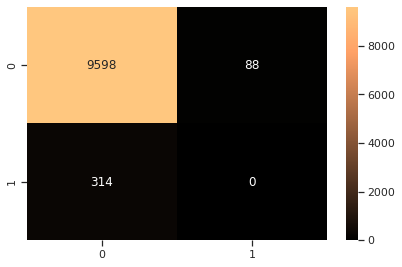

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0,0.990915,-0.00181706




Additional Info
Total predicted to be positive: 88 

First 23 matches
23 [ 18  35  52 102 113 193 197 201 210 216 219 272 283 298 392 421 430 479
 496 500 537 546 567]

[0.50047475 0.5065777  0.50019765 0.5006666  0.5003708  0.5079532
 0.50398654 0.50086135 0.505978   0.5030623  0.50102323 0.5028452
 0.5036742  0.5054695  0.5038883  0.50297743 0.5026455  0.50568193
 0.50018847 0.5010443  0.50296575 0.50008357 0.5032933 ]


Top 23 Probable Matches

[ 594  851  298 5378  950  479   35  210  661  817  895 2479 1949 3591
  592 1271 5311  823 5301  903  905  193 6114]


[0.5042397  0.5050064  0.5054695  0.50557655 0.50564355 0.50568193
 0.5065777  0.505978   0.5071142  0.5065268  0.50594264 0.50766134
 0.50810057 0.50840396 0.509803   0.51017755 0.5118275  0.50851315
 0.5084075  0.5112606  0.5128101  0.5079532  0.51000243]


2 To 3 Digits

48 [ 18  35  52 102 113 193 197 201 210 216 219 272 283 298 392 421 430 479
 496 500 537 546 567 575 581 591 592 594 595 641 661 722 743 757 793 809
 8

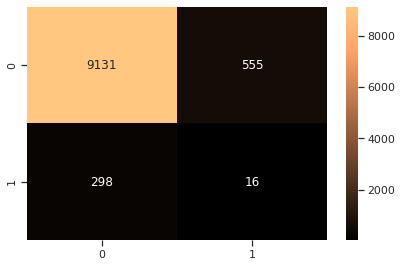

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0509554,0.942701,0.0293045




Additional Info
Total predicted to be positive: 571 

First 23 matches
23 [  0  13  18  28  35  38  49  50  52  54  72 115 129 131 132 151 152 157
 191 193 197 199 201]

[0.50413847 0.5002217  0.50006616 0.5021551  0.5032792  0.50465155
 0.50341624 0.5009241  0.5072087  0.50038594 0.5058201  0.5008668
 0.50156736 0.5007035  0.5003339  0.5046549  0.50409085 0.50177723
 0.5025076  0.50026697 0.5075089  0.5018669  0.5071188 ]


Top 23 Probable Matches

[ 950  743 1702  952  895 1253  716  810  823 1017 1124 1933 5311  496
 7455 8938  592  757 1271 7227  905 1949  903]


[0.509516   0.5096999  0.50994587 0.50999683 0.5116503  0.511409
 0.51005256 0.51041096 0.51119834 0.5107674  0.5107543  0.5101104
 0.5103369  0.51160264 0.51246256 0.5127638  0.51573944 0.5132612
 0.5183879  0.5147575  0.5145803  0.51473504 0.5127703 ]


2 To 3 Digits

180 [ 13  18  28  35  38  49  50  52  54  72 115 129 131 132 151 152 157 191
 193 197 199 201 203 210 219 220 226 230 239 253 259 266 270 271 272 279
 28

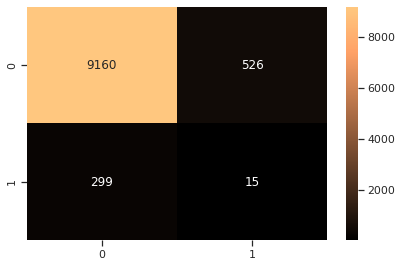

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0477707,0.945695,0.0273555




Additional Info
Total predicted to be positive: 541 

First 23 matches
23 [  0  13  28  35  38  49  50  52  54  72 115 129 131 132 151 152 157 191
 193 197 199 201 203]

[0.5039194  0.5000024  0.5019386  0.5030635  0.50443363 0.503197
 0.50070465 0.5069898  0.50016826 0.505601   0.5006484  0.501348
 0.5004853  0.5001155  0.5044355  0.5038719  0.5015579  0.5022883
 0.50005233 0.5072926  0.50165063 0.50689965 0.5023163 ]


Top 23 Probable Matches

[ 950  743 1702  952  716 5311 1933  810 1124 1017  823 1253  895 7455
 1271 8938  903 7227  592  496  905 1949  757]


[0.50930166 0.50948113 0.50972784 0.50978    0.5098344  0.51013005
 0.50990534 0.5101931  0.51054806 0.510549   0.5109861  0.5111902
 0.5114313  0.51224893 0.51817244 0.5125519  0.51255107 0.51453996
 0.5155313  0.5113852  0.5143667  0.51452684 0.5130426 ]


2 To 3 Digits

176 [ 13  28  35  38  49  50  52  54  72 115 129 131 132 151 152 157 191 193
 197 199 201 203 210 219 220 226 230 239 253 259 266 270 271 272 279 282
 283

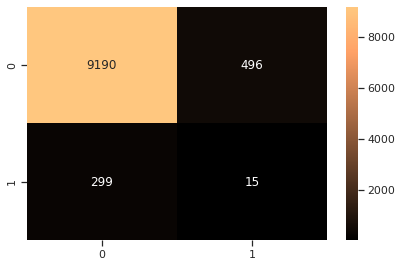

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0477707,0.948792,0.027975




Additional Info
Total predicted to be positive: 511 

First 23 matches
23 [  0  28  35  38  49  50  52  72 115 129 131 151 152 157 191 197 199 201
 203 210 219 220 226]

[0.50370014 0.50172174 0.5028475  0.5042154  0.5029777  0.5004849
 0.50677055 0.5053818  0.50042975 0.5011283  0.5002669  0.5042159
 0.50365263 0.5013382  0.5020686  0.5070762  0.5014342  0.5066802
 0.50209713 0.50310034 0.5045716  0.5029628  0.50107896]


Top 23 Probable Matches

[ 743 1702  952  716  592  895 7455  823  903 5378 1124 1017 1253 5311
  905 8938  810  496  757 7227 1949 1933 1271]


[0.5092624  0.50950944 0.5095632  0.509616   0.5154204  0.51121235
 0.51203203 0.51077116 0.5123318  0.50986165 0.5103349  0.5103305
 0.5109712  0.51464385 0.5141511  0.5124334  0.5099751  0.5111675
 0.5128239  0.51432294 0.5143144  0.5096884  0.5179553 ]


2 To 3 Digits

169 [ 28  35  38  49  50  52  72 115 129 131 151 152 157 191 197 199 201 203
 210 219 220 226 239 253 259 266 270 271 272 279 282 283 291 305 316 317
 32

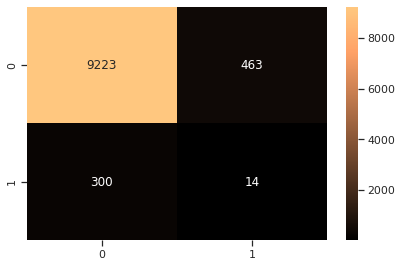

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.044586,0.952199,0.0261086




Additional Info
Total predicted to be positive: 477 

First 23 matches
23 [  0  28  35  38  49  50  52  72 115 129 131 151 152 157 191 197 199 201
 203 210 219 220 226]

[0.5034807  0.5015047  0.5026313  0.5039971  0.5027581  0.50026494
 0.50655115 0.5051623  0.5002109  0.5009085  0.50004834 0.5039961
 0.5034333  0.5011184  0.50184876 0.5068595  0.50121754 0.5064606
 0.5018777  0.50288165 0.50435305 0.50274366 0.5008592 ]


Top 23 Probable Matches

[ 743 1702  905 5378  903  952 1271  895 1017  823 1124  810 1253 7455
 5311 8938  716 7227  592  496 1949 1933  757]


[0.5090432  0.5092909  0.51393706 0.509653   0.51211214 0.50934595
 0.51773936 0.5109929  0.51011175 0.5105585  0.5101283  0.5097568
 0.5107519  0.511818   0.51443523 0.51222104 0.50939745 0.5141049
 0.51521176 0.5109496  0.5141058  0.50948286 0.5126049 ]


2 To 3 Digits

162 [ 28  35  38  49  50  52  72 115 129 131 151 152 157 191 197 199 201 203
 210 219 220 226 239 253 259 270 271 272 279 282 283 291 305 316 317 322
 3

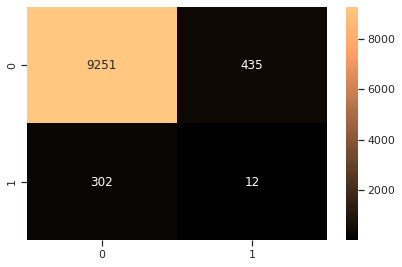

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0382166,0.95509,0.0215912




Additional Info
Total predicted to be positive: 447 

First 23 matches
23 [  0  28  35  38  49  50  52  72 129 151 152 157 191 197 199 201 203 210
 219 220 226 239 253]

[0.5032609  0.50128746 0.5024149  0.5037784  0.5025382  0.5000448
 0.5063315  0.5049426  0.50068843 0.503776   0.50321364 0.5008984
 0.5016287  0.5066426  0.50100064 0.5062408  0.5016581  0.5026628
 0.5041343  0.50252426 0.5006392  0.500425   0.5013824 ]


Top 23 Probable Matches

[ 743 1702 5378  905  903  952 1271  895 1017  823 1124  810 1253 7455
 1949 8938  716 7227  592  496 1933 5311  757]


[0.5088238  0.5090721  0.5094441  0.5137227  0.51189226 0.5091285
 0.51752317 0.51077324 0.5098927  0.51034564 0.50992143 0.50953835
 0.5105324  0.5116037  0.51389694 0.5120085  0.5091786  0.51388675
 0.51500297 0.51073146 0.50927716 0.51422644 0.5123856 ]


2 To 3 Digits

150 [ 28  35  38  49  50  52  72 129 151 152 157 191 197 199 201 203 210 219
 220 226 239 253 259 270 271 272 279 282 283 291 305 316 322 344 352 362
 3

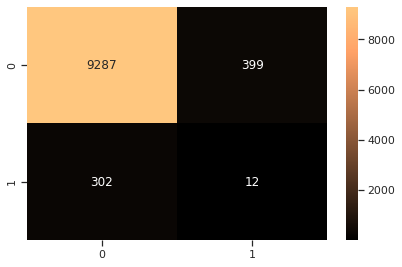

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0382166,0.958807,0.0223346




Additional Info
Total predicted to be positive: 411 

First 23 matches
23 [  0  28  35  38  49  52  72 129 151 152 157 191 197 199 201 203 210 219
 220 226 239 253 259]

[0.50304145 0.50107026 0.50219864 0.50356    0.50231856 0.50611204
 0.50472313 0.50046873 0.5035562  0.5029953  0.5006789  0.50140893
 0.50642556 0.5007841  0.5060218  0.50143844 0.502444   0.5039159
 0.5023479  0.5004193  0.5002056  0.5011625  0.50463665]


Top 23 Probable Matches

[ 743 1933 1702  952  716 5378  757 7455 1253 1271  905 1949  895 5311
 8938  592 1124 1017  496  810 7227  823  903]


[0.50860435 0.50911236 0.50885326 0.50891155 0.50895995 0.50927484
 0.5121666  0.51142913 0.5103129  0.51734793 0.51354915 0.5137289
 0.51055366 0.5140567  0.51183665 0.51483285 0.50975406 0.5096737
 0.51051354 0.50931996 0.513708   0.5101731  0.511673  ]


2 To 3 Digits

141 [ 28  35  38  49  52  72 129 151 152 157 191 197 199 201 203 210 219 220
 226 239 253 259 270 271 272 279 282 283 291 305 316 322 344 352 362 363
 

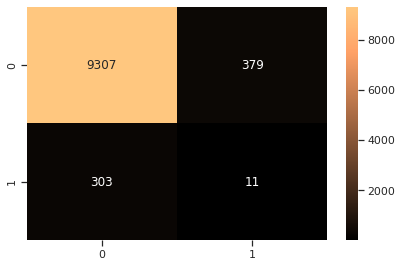

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0350318,0.960871,0.0201997




Additional Info
Total predicted to be positive: 390 

First 23 matches
23 [  0  28  35  38  49  52  72 129 151 152 157 191 197 199 201 203 210 219
 220 226 253 259 270]

[0.5028167  0.50085217 0.5019813  0.50333637 0.50209785 0.5058919
 0.5044987  0.500248   0.5033356  0.5027754  0.50045836 0.5011883
 0.50620776 0.5005621  0.5058014  0.50121343 0.5022243  0.50369674
 0.5021277  0.5001986  0.50094193 0.50441605 0.50069284]


Top 23 Probable Matches

[ 743 1702  952  716 1933 5378  810 1271 1253  592 1949 8938 1124 1017
  496 7455 7227 5311  757  905  903  895  823]


[0.50838405 0.5086335  0.5086889  0.50873566 0.50890535 0.5090646
 0.50910056 0.51713073 0.5100925  0.51462257 0.5135242  0.51162285
 0.5095463  0.5094491  0.51028997 0.51121384 0.51348954 0.5138465
 0.51194626 0.51333374 0.5114531  0.51033336 0.5113597 ]


2 To 3 Digits

133 [ 28  35  38  49  52  72 129 151 152 157 191 197 199 201 203 210 219 220
 226 253 259 270 271 272 279 282 283 291 305 316 322 344 352 362 363 365
 3

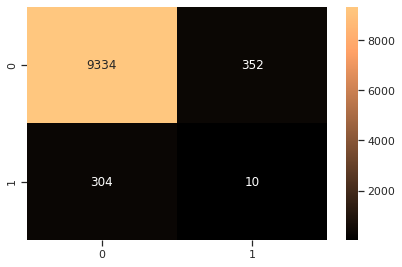

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0318471,0.963659,0.0182095




Additional Info
Total predicted to be positive: 362 

First 23 matches
23 [  0  28  35  38  49  52  72 129 151 152 157 191 197 199 201 203 210 219
 220 226 253 259 270]

[0.5025246  0.50298053 0.50225586 0.5029296  0.5018656  0.5056468
 0.50408113 0.50000626 0.50321937 0.50236297 0.50015867 0.50089604
 0.5084539  0.50016785 0.5055795  0.50083375 0.5019803  0.50656515
 0.5016999  0.5000957  0.50070685 0.5039566  0.5004158 ]


Top 23 Probable Matches

[ 851  716  952 5378 1933  197  496 1124 1017 1702 1253  757  903  895
 8938  823 7455  905 1271 7227 5311  592 1949]


[0.50796664 0.5079848  0.50829095 0.50836444 0.5084279  0.5084539
 0.5086327  0.509028   0.5090513  0.5091217  0.5093188  0.511518
 0.5112182  0.5099969  0.51070994 0.50932044 0.5106579  0.51243687
 0.51628405 0.51253957 0.51327294 0.5137419  0.5135847 ]


2 To 3 Digits

127 [ 28  35  38  49  52  72 129 151 152 157 191 197 199 201 203 210 219 220
 226 253 259 270 271 272 279 282 283 291 305 322 344 352 362 363 365 384
 3

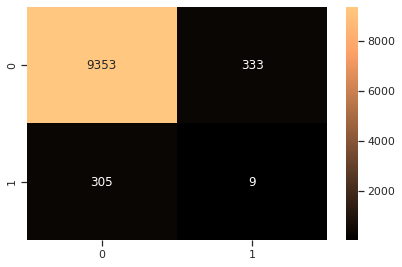

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0286624,0.96562,0.016054




Additional Info
Total predicted to be positive: 342 

First 23 matches
23 [  0  28  35  38  49  52  72 151 152 191 197 201 203 210 219 220 253 259
 270 271 272 279 282]

[0.502304   0.50276214 0.5020382  0.5027101  0.50164485 0.5054262
 0.5038605  0.5029984  0.5021424  0.5006751  0.50823575 0.5053587
 0.5006133  0.50176054 0.5063442  0.5014796  0.500486   0.5037357
 0.500195   0.50329703 0.50204563 0.5035334  0.50152487]


Top 23 Probable Matches

[ 851  716  952 5378 1933  197  496 1124 1017 1702 1253  757  903  895
 8938  823 7455  905 1271 7227 5311  592 1949]


[0.5077461  0.50776505 0.50807256 0.5081547  0.50822127 0.50823575
 0.50841373 0.5088203  0.5088314  0.5089022  0.5090984  0.5112978
 0.5109974  0.50977623 0.51049644 0.50910664 0.51044273 0.51222163
 0.5160669  0.5123204  0.51306325 0.51353216 0.51337427]


2 To 3 Digits

121 [ 28  35  38  49  52  72 151 152 191 197 201 203 210 219 220 253 259 270
 271 272 279 282 283 291 305 322 344 352 362 363 365 384 385 391 392 421
 4

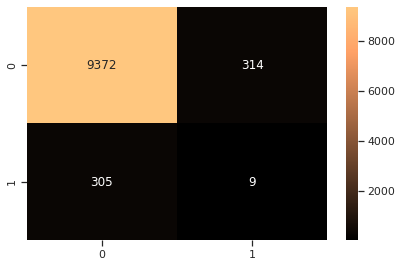

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0286624,0.967582,0.0164464




Additional Info
Total predicted to be positive: 323 

First 23 matches
23 [  0  28  35  38  49  52  72 151 152 191 197 201 203 210 219 220 253 259
 271 272 279 282 283]

[0.5020832  0.50254345 0.5018203  0.5024904  0.5014239  0.5052055
 0.50363964 0.5027772  0.5019217  0.5004539  0.5080174  0.5051378
 0.50039256 0.50154054 0.506123   0.50125915 0.50026494 0.50351465
 0.50307596 0.5018258  0.50331235 0.50130385 0.5074016 ]


Top 23 Probable Matches

[ 851  716  952 5378 1933 1017  496  197 1124 1702 1253  757  903  895
 8938  823 7455  905 1271 7227 5311  592 1949]


[0.5075253  0.5075451  0.507854   0.5079447  0.50801444 0.5086112
 0.50819457 0.5080174  0.50861233 0.5086824  0.50887775 0.51107746
 0.51077634 0.5095554  0.5102827  0.50889266 0.5102273  0.51200616
 0.5158496  0.51210105 0.5128534  0.5133222  0.51316357]


2 To 3 Digits

117 [ 28  35  38  49  52  72 151 152 191 197 201 203 210 219 220 253 259 271
 272 279 282 283 291 305 322 344 352 362 363 384 385 391 392 421 430 431
 

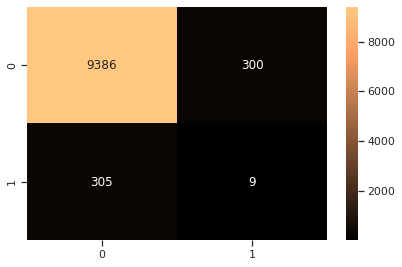

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0286624,0.969027,0.0167354




Additional Info
Total predicted to be positive: 309 

First 23 matches
23 [  0  28  35  38  49  52  72 151 152 197 201 203 210 219 220 259 271 272
 279 282 283 291 305]

[0.5019665  0.5027204  0.5023893  0.5026118  0.5012776  0.50503844
 0.5033864  0.50204885 0.5019669  0.5085454  0.50524765 0.50001925
 0.5015484  0.50568604 0.5006146  0.5033945  0.50276256 0.501917
 0.50324786 0.50127417 0.5076516  0.5032323  0.50333315]


Top 23 Probable Matches

[ 421  810 5378  952  823 1949  905  903 1933  895  496 7455 1017 5311
 7227 1271 1702  592 1124  197 8938 1253  757]


[0.50770116 0.50789845 0.5078304  0.50797135 0.5080642  0.5130524
 0.51160914 0.51088476 0.5088386  0.51001275 0.5086242  0.51015526
 0.508721   0.51274097 0.5119581  0.5157732  0.5085129  0.512798
 0.5096318  0.5085454  0.5101713  0.5091285  0.51132655]


2 To 3 Digits

108 [ 28  35  38  49  52  72 151 152 197 201 203 210 219 220 259 271 272 279
 282 283 291 305 322 344 352 362 363 384 385 391 392 421 430 431 437 446
 47

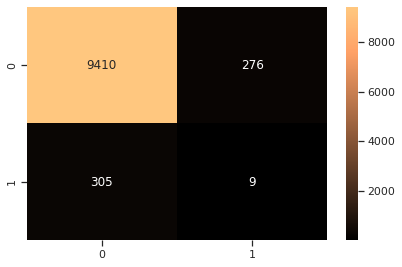

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0286624,0.971505,0.017231




Additional Info
Total predicted to be positive: 285 

First 23 matches
23 [  0  28  35  38  49  52  72 151 152 197 201 210 219 220 259 271 272 279
 282 283 291 305 322]

[0.5017452  0.50250125 0.5021709  0.50239164 0.5010562  0.50481725
 0.5031651  0.50182724 0.5017457  0.50832665 0.5050263  0.50132793
 0.5054644  0.50039357 0.50317293 0.50254095 0.50169677 0.5030263
 0.50105274 0.5074299  0.5030105  0.50311244 0.5033235 ]


Top 23 Probable Matches

[ 421  810 5378  952  823 1949  905  903 1933  895  496 7455 1017 5311
 7227 1271 1702  592 1124  197 8938 1253  757]


[0.5074803  0.50767845 0.5076199  0.5077523  0.5078498  0.5128413
 0.51139313 0.5106633  0.50863147 0.5097915  0.50840455 0.5099394
 0.50850034 0.51253057 0.51173824 0.5155553  0.50829273 0.51258755
 0.50942355 0.50832665 0.50995713 0.50890744 0.5111057 ]


2 To 3 Digits

101 [ 28  35  38  49  52  72 151 152 197 201 210 219 220 259 271 272 279 282
 283 291 305 322 344 352 362 363 385 391 392 421 430 431 437 446 479 495
 

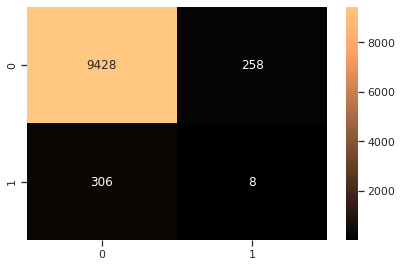

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0254777,0.973364,0.0150549




Additional Info
Total predicted to be positive: 266 

First 23 matches
23 [  0  28  35  38  49  52  72 151 152 197 201 210 219 220 259 271 272 279
 282 283 291 305 322]

[0.5014462  0.5019117  0.5011512  0.50181746 0.5007477  0.50477576
 0.50300187 0.5021393  0.5012974  0.5073838  0.5044986  0.500866
 0.5052883  0.5003231  0.5028755  0.5026096  0.5011907  0.50288284
 0.50066566 0.50676185 0.50325227 0.5020875  0.50287765]


Top 23 Probable Matches

[ 716  851 5378  952  197 1933 1017  496 1124  823 7227 1949  905 8938
  903  757  895  592 1253 1702 1271 7455 5311]


[0.50687164 0.50688666 0.507313   0.5071843  0.5073838  0.5073963
 0.5079365  0.5075232  0.5077159  0.5079775  0.51144326 0.5125369
 0.5110818  0.5096384  0.5101362  0.5104021  0.50912356 0.51241726
 0.50820214 0.5080564  0.5151967  0.50957805 0.5122227 ]


2 To 3 Digits

100 [ 28  35  38  49  52  72 151 152 197 201 210 219 220 259 271 272 279 282
 283 291 305 322 344 352 362 363 385 391 392 421 430 431 437 446 479 495
 4

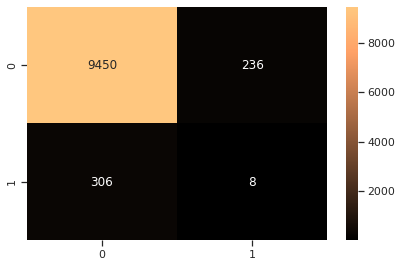

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0254777,0.975635,0.0155092




Additional Info
Total predicted to be positive: 244 

First 23 matches
23 [  0  28  35  38  49  52  72 151 152 197 201 210 219 220 259 271 272 279
 282 283 291 305 322]

[0.5012245  0.5016922  0.50093246 0.50159687 0.50052583 0.5045541
 0.50278014 0.5019172  0.5010758  0.5071646  0.50427675 0.5006451
 0.5050662  0.5001017  0.5026535  0.5023876  0.5009701  0.5026608
 0.50044376 0.5065397  0.50303006 0.5018663  0.5026557 ]


Top 23 Probable Matches

[ 716  851 5378  952  197 1933 1017  496 1124  823 7227 1949  905 8938
  903  757  895  592 1253 1702 1271 7455 5311]


[0.50665075 0.50666493 0.50710213 0.50696486 0.5071646  0.50718856
 0.5077154  0.50730306 0.507507   0.5077626  0.51122296 0.51232535
 0.51086545 0.5094238  0.5099143  0.5101807  0.50890183 0.5122064
 0.50798064 0.50783575 0.5149784  0.50936174 0.5120119 ]


2 To 3 Digits

92 [ 28  35  38  49  52  72 151 152 197 201 210 219 220 259 271 272 279 282
 283 291 305 322 352 363 391 392 421 430 431 437 446 479 495 496 498 507
 53

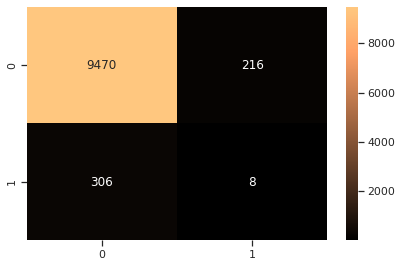

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0254777,0.9777,0.0159221




Additional Info
Total predicted to be positive: 224 

First 23 matches
23 [  0  28  35  38  49  52  72 151 152 197 201 210 219 259 271 272 279 282
 283 291 305 322 352]

[0.5009679  0.50153726 0.5007786  0.5014401  0.5002681  0.50429815
 0.50252366 0.5016601  0.5008194  0.5069091  0.50402004 0.5003876
 0.50480956 0.50239694 0.5022312  0.5007147  0.50240433 0.5001851
 0.50628203 0.5027731  0.50171    0.5023995  0.5000503 ]


Top 23 Probable Matches

[ 851  716  952  197 5378 1933  823 1124 5311 1253 7227  905  903 1949
 1017  757  592 1702  895  496 1271 7455 8938]


[0.506407   0.506494   0.5068089  0.5069091  0.5068928  0.5069802
 0.50754875 0.50729656 0.51185143 0.50782365 0.5110027  0.5106497
 0.5096569  0.5121636  0.50755763 0.510023   0.5119955  0.5075797
 0.50864536 0.5071479  0.51481014 0.50919574 0.5092105 ]


2 To 3 Digits

87 [ 28  35  38  49  52  72 151 152 197 201 210 219 259 271 272 279 282 283
 291 305 322 352 363 391 392 421 430 431 437 446 479 495 496 498 507 535
 537

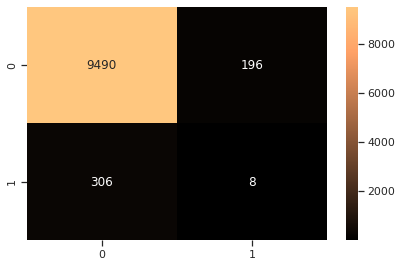

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0254777,0.979765,0.0163351




Additional Info
Total predicted to be positive: 204 

First 23 matches
23 [  0  28  35  38  49  52  72 151 152 197 201 210 219 259 271 272 279 283
 291 305 322 363 391]

[0.5007456  0.5013174  0.5005593  0.5012191  0.5000458  0.50407594
 0.50230116 0.5014375  0.500597   0.5066896  0.5037975  0.500166
 0.5045868  0.5021744  0.5020066  0.5004934  0.5021817  0.50605935
 0.50255024 0.5014884  0.50217694 0.50051135 0.50011945]


Top 23 Probable Matches

[ 851  716  952  496 1933 5378  197 1124 8938  905 7227  823 7455  903
 1017  592 1271 5311 1253 1949  895  757 1702]


[0.5061849  0.50627244 0.50658864 0.5069271  0.50677043 0.50668013
 0.5066896  0.5070857  0.508994   0.5104317  0.5107807  0.50733197
 0.50897807 0.5094344  0.5073359  0.51178277 0.5145902  0.51163894
 0.5076015  0.5119502  0.5084232  0.50980103 0.50735855]


2 To 3 Digits

82 [ 28  35  38  49  52  72 151 152 197 201 210 219 259 271 272 279 283 291
 305 322 363 391 392 421 430 431 437 446 479 495 496 498 507 537 538 557
 

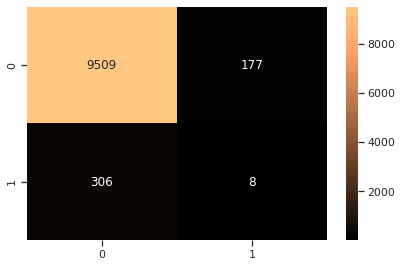

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0254777,0.981726,0.0167274




Additional Info
Total predicted to be positive: 185 

First 23 matches
23 [  0  28  35  38  52  72 151 152 197 201 219 259 271 272 279 283 291 305
 322 363 392 421 430]

[0.5005232  0.50109714 0.50033987 0.5009978  0.50385356 0.5020788
 0.50121474 0.50037473 0.50646967 0.50357497 0.50436395 0.5019517
 0.50178385 0.50027204 0.501959   0.50583655 0.5023274  0.5012666
 0.5019544  0.50029105 0.5053122  0.5054759  0.50262535]


Top 23 Probable Matches

[ 851  716  952  496 1933 5378  197 1124 8938  905 7227  823 7455  903
 1017  592 1271 5311 1253 1949  895  757 1702]


[0.5059625  0.5060508  0.5063684  0.5067063  0.506562   0.5064686
 0.50646967 0.5068762  0.5087787  0.5102146  0.5105597  0.5071164
 0.5087611  0.5092118  0.5071141  0.5115712  0.51437134 0.51142746
 0.5073793  0.51173794 0.50820076 0.50957906 0.5071372 ]


2 To 3 Digits

78 [ 28  35  38  52  72 151 152 197 201 219 259 271 272 279 283 291 305 322
 363 392 421 430 431 437 446 479 495 496 498 507 537 538 557 567 568 587
 591

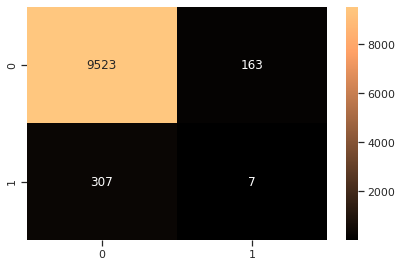

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.022293,0.983172,0.0144687




Additional Info
Total predicted to be positive: 170 

First 23 matches
23 [  0  28  35  38  52  72 151 152 197 201 219 259 271 272 279 283 291 305
 322 363 392 421 430]

[0.5003006  0.50087667 0.5001202  0.50077623 0.503631   0.5018561
 0.50099176 0.50015223 0.5062495  0.5033522  0.504141   0.50172883
 0.50156087 0.50005054 0.5017361  0.50561345 0.5021042  0.5010446
 0.5017315  0.5000706  0.5050895  0.5052536  0.5024039 ]


Top 23 Probable Matches

[ 851  716  823 1702 5378 1124  952 7455  197  895 1933 1253  496 1017
 8938 1949  757  903 5311 1271 7227  592  905]


[0.50573987 0.50582904 0.5069006  0.5069156  0.50625676 0.5066664
 0.506148   0.5085439  0.5062495  0.50797814 0.5063534  0.5071568
 0.5064853  0.50689214 0.50856316 0.5115255  0.50935686 0.5089889
 0.51121575 0.51415205 0.5103385  0.51135945 0.5099973 ]


2 To 3 Digits

75 [ 28  35  38  52  72 151 152 197 201 219 259 271 272 279 283 291 305 322
 363 392 421 430 431 437 446 479 495 496 498 507 537 538 557 567 568 587
 591

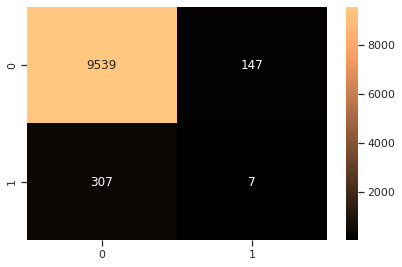

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.022293,0.984823,0.0147991




Additional Info
Total predicted to be positive: 154 

First 23 matches
23 [  0  28  38  52  72 151 197 201 219 259 271 279 283 291 305 322 392 421
 430 431 437 446 479]

[0.5000777  0.50065595 0.50055444 0.5034082  0.5016332  0.5007686
 0.50602907 0.50312924 0.5039177  0.5015056  0.5013377  0.501513
 0.50539005 0.5018809  0.50082225 0.5015084  0.50486666 0.50503117
 0.50218225 0.5029067  0.5010151  0.5045235  0.5026438 ]


Top 23 Probable Matches

[ 851  716  823 1702 5378 1124  952 7455  197  895 1933 1253  496 1017
 8938 1949  757  903 5311 1271 7227  592  905]


[0.505517   0.505607   0.50668454 0.5066938  0.50604475 0.5064564
 0.5059273  0.5083265  0.50602907 0.5077552  0.5061445  0.50693405
 0.50626403 0.50666994 0.5083474  0.5113128  0.50913435 0.5087658
 0.51100373 0.51393265 0.510117   0.5111474  0.5097798 ]


2 To 3 Digits

70 [ 28  38  52  72 151 197 201 219 259 271 279 283 291 305 322 392 421 430
 431 437 446 479 495 496 498 507 537 538 557 567 568 587 591 592 594 603
 604

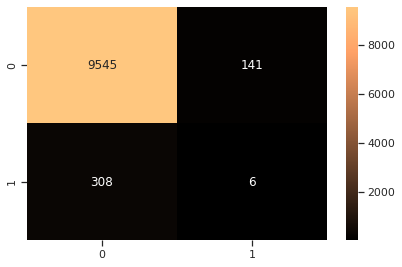

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0191083,0.985443,0.0123752




Additional Info
Total predicted to be positive: 147 

First 23 matches
23 [ 28  38  52  72 151 197 201 219 259 271 279 283 291 305 322 392 421 430
 431 437 446 479 495]

[0.5004352  0.5003325  0.50318515 0.50141007 0.50054514 0.5058085
 0.5029059  0.5036942  0.5012822  0.5011164  0.50128967 0.5051664
 0.5016573  0.50059986 0.50128514 0.50464356 0.5048085  0.50196224
 0.5026855  0.5007943  0.5043001  0.5024204  0.5016973 ]


Top 23 Probable Matches

[ 851  716 5378  197  952 1933  496 1124  895 1702 1253 1017 7455  823
 8938 5311  903  905 7227  592 1271  757 1949]


[0.505294   0.50538474 0.50583357 0.5058085  0.5057064  0.5059366
 0.5060427  0.506247   0.5075321  0.50647175 0.50671124 0.5064474
 0.50811046 0.506469   0.5081319  0.51079285 0.5085423  0.50956327
 0.5098971  0.51093584 0.5137148  0.50891167 0.51110137]


2 To 3 Digits

69 [ 28  38  52  72 151 197 201 219 259 271 279 283 291 305 322 392 421 430
 431 437 446 479 495 496 498 507 537 538 557 567 568 587 591 592 594 603
 60

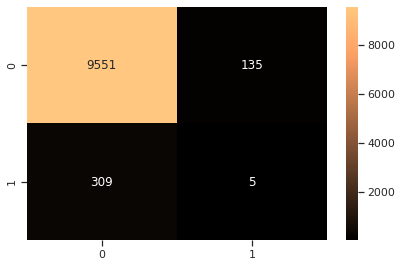

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0159236,0.986062,0.00995133




Additional Info
Total predicted to be positive: 140 

First 23 matches
23 [ 28  38  52  72 151 197 201 219 259 271 279 283 291 305 322 392 421 430
 431 437 446 479 495]

[0.50021404 0.5001102  0.5029619  0.5011867  0.5003215  0.50558764
 0.50268245 0.5034704  0.50105864 0.50089276 0.5010661  0.5049426
 0.50143355 0.5003771  0.5010616  0.5044202  0.50458556 0.5017401
 0.50246406 0.50057316 0.50407654 0.50219685 0.5014746 ]


Top 23 Probable Matches

[ 851  716 5378  197  952 1933 8938  496 1949 1271  757  823 7455  592
 1017 7227  905 1702  903 5311 1253  895 1124]


[0.50507075 0.50516224 0.5056211  0.50558764 0.5054853  0.5057273
 0.50791574 0.505821   0.5108882  0.5134949  0.5086887  0.5062526
 0.5078926  0.5107233  0.5062247  0.50967515 0.5093453  0.5062494
 0.5083187  0.5105804  0.5064881  0.5073088  0.5060365 ]


2 To 3 Digits

69 [ 28  38  52  72 151 197 201 219 259 271 279 283 291 305 322 392 421 430
 431 437 446 479 495 496 498 507 537 538 557 567 568 587 591 592 594 603
 604

In [0]:
start_mt = pd.datetime(2019,7,1)
how_many_mt = 6 
for i in range(how_many_mt):
  month_to_predict = start_mt + relativedelta(months=i)
  print(f"\n{month_to_predict}\n-------------------\n")

  weight=1.0
  decrement = 0.000
  to_stop=False

  gen_train_test_set(month_to_predict, feature_matrix_selection, file_prefix='test')
  while not to_stop:
    to_stop = model(month_to_predict, feature_matrix_selection, file_prefix='test', class_weight=(weight-decrement))
    decrement = decrement + 0.001
